### Proxilmal Policy Optimization

This is an implementation of the following paper by <a href="https://openai.com/">OpenAI</a><br>
<b><I>Proximal Policy Optimization Algorithms</b></I> <a href="https://arxiv.org/abs/1707.06347">arxiv link</a><br><br>
Implemented by : Irfan Mohammad Al Hasib <br>
E-Mail : irfanhasib.me@gmail.com <br>
Website : <a href="https://irfanhasib0.github.io">https://irfanhasib0.github.io</a><br>
LinkedIN : <a href="https://www.linkedin.com/in/irfanhasib/">https://www.linkedin.com/in/irfanhasib/</a><br>

1. Impletated from scratch with tensorflow
2. Tested for Bipedal walker environment of OpenAI <br>



### Importing necessary libraries

In [1]:
seed=1
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED']=str(seed)
import numpy as np
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense ,Input,concatenate ,Conv2D,Conv2DTranspose,\
MaxPooling2D,AveragePooling2D, LSTM ,Reshape, TimeDistributed,ReLU, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam,Adagrad
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import warnings
import glob
import math
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from collections import deque
from tqdm import tqdm,trange
import gym
import imageio
from datetime import datetime
from copy import copy , deepcopy
TanH=tf.keras.layers.Activation('tanh')
Sigmoid=tf.keras.layers.Activation('sigmoid')

### Basic settings and paths

In [2]:
train_ppo_agent=True
env_name = 'BipedalWalker-v2'
exp_root_path='exps/ppo_exp_1'
if not os.path.exists(exp_root_path): os.makedirs(exp_root_path)

### Hiperparameters setting

In [3]:
params_dict={
'_actor_lr' : 0.001,
'_critic_lr' : 0.001,
'_value_coef' : 0.5,
'_entropy_coef' : 0.01,
'_gamma' : 0.99,
'_lambda' : 0.95,
'_clip_epsilon' : 0.05,
'_advantage' : 10,
'_time_steps' : 2000,
'_episodes' : 1000,
'_train_steps': 5
}
param_str='Time : '+str(datetime.now()) +'\n'+'Exp Name : ' + exp_root_path+'\n'
for key in params_dict.keys():
    param_str += str( key + ' = '+str(params_dict[key]) +'\n' )
with open(exp_root_path+'/params.txt','w') as file:
    file.write(param_str)

###  Classes definations
1. Class Actor():

        Class for creating actor Network inheriting tensorflow.keras Model class
        
        -> __init__ : Layer definations
        -> call() : Network building
2. Class Critic():
        
        -Class for creating actor Network inheriting tensorflow.keras Model class
        
        -> __init__ : Layer definations
        -> call() : Network building
        
3. Class Memory():
        
        Class for storing data samples and retriving when necessary. Each data sample to be stored consists of : state , action , mean, std, value, mask, reward
        
        -> append(data sample) appends one sample 
        -> retrive() -> data sample, retrives all the stored samples and cleares memory
4. Class Environment():
        
        
        A wrapper around OpenAI environment. 
        
        -> reset() resets the environment
        -> step() takes action and returns obserrvation, reward, terminal, info
        -> render() renders current environment image
        -> close() closes environment instance
        
4. CLass PPO_Model() : 
            
         Takes all the hiperparameters as input.
         
        -> calc_gae_values : Calculates generalized advantage estimations from values, rewards and masks
        -> calc_actor_loss : Calculates actor loss
        -> train actor : Trains actor model with calculated loss
        -> calc critic loss : Calculate critic loss
        -> train critic : Trains Critic model with calculated loss
        -> test model : Test the actor model for environment and returns test reward
        
        -> get_log_probability : calculates log of gaussian probabilities from action , mean and std
        -> get_entropy : calculates entropy from std

In [4]:
class Environment():
    def __init__(self,seed=seed):
        self.env= gym.make(env_name)
        self.env.seed(seed)
        self.n_states = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.shape[0]
        
    def reset(self):
        return self.env.reset()
        
    def step(self,action):
        
        action = np.clip(action,-1.0,1.0)
        observation, reward, done, info = self.env.step(action)
        if reward == -100:
            reward=-2
        mask = not done
        return observation, reward, mask, info
    
    def render(self,opt):
        return self.env.render(opt)
    
    def close(self):
        self.env.close()

class Actor(Model):
    def __init__(self,n_act):
        super(Actor, self).__init__()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.mean = Dense(n_act)
        self.tanh  = TanH
        self.sigmoid  = Sigmoid
        self.std = Dense(n_act)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        mean = self.mean(x)
        mean = self.tanh(mean)
        std = self.std(x)
        std = self.sigmoid(std)
        return mean,std+10e-10


class Critic(Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.d1 = Dense(512, activation='relu')
        self.d2 = Dense(256, activation='relu')
        self.value = Dense(1)

    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        value = self.value(x)
        return value
    
class Memory():
        def __init__(self,_len=None,n_states=None,n_actions=None):
            self._len=_len
            self.n_states=n_states
            self.n_actions=n_actions
            self.clear()

        def clear(self):
            _len=self._len
            self.curr_states = np.zeros((_len,self.n_states),dtype=np.float32)
            self.old_actions = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.values = np.zeros((_len,1),dtype=np.float32)
            self.masks = np.zeros((_len,1),dtype=np.float32)
            self.rewards = np.zeros((_len,1),dtype=np.float32)
            self.old_means = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.old_stds  = np.zeros((_len,self.n_actions),dtype=np.float32)
            self.i=0
            
        def append(self,state,action,mean,std,q_value,mask,reward):
            self.curr_states[self.i,:]=state
            self.old_actions[self.i,:]=action
            self.old_means[self.i,:]=mean
            self.old_stds[self.i,:]=std
            self.values[self.i,:]=q_value
            self.masks[self.i,:]=mask
            self.rewards[self.i,:]=reward
            self.i+=1
        
        def retrive(self):
            curr_states=self.curr_states.copy()
            old_actions=self.old_actions.copy()
            old_means=self.old_means.copy()
            old_stds=self.old_stds.copy()
            values=self.values.copy()
            rewards=self.rewards.copy()
            masks  = self.masks.copy()
            self.clear()
            return curr_states,old_actions,old_means,old_stds,values,rewards,masks
        
class PPO_Model():
    def __init__(self,n_actions=None,_actor_lr = 0.001, _critic_lr = 0.001,_value_coef=0.5,_entropy_coef=0.01,_gamma=0.99,
                _lambda=0.95,_clip_epsilon=0.05,_advantage= 10, _time_steps=2000,_episodes=1000,_train_steps=5):
        self._actor=Actor(n_actions)
        self._critic=Critic()

        self._actor_opt= Adam(_actor_lr)
        self._critic_opt= Adam(_critic_lr)
        self._value_coef=_value_coef
        self._entropy_coef= _entropy_coef
        self._gamma= _gamma
        self._lambda= _lambda
        self._clip_epsilon= _clip_epsilon
        self._advantage= _advantage
        self._time_steps = _time_steps
        self._episodes = _episodes
        self._train_steps = _train_steps
        
    def calc_gae_values(self,n_values, n_masks, n_rewards):
        target_qvals = []
        for i in range(len(n_rewards)-self._advantage):
            values=n_values[i:i+self._advantage+1]
            rewards=n_rewards[i:i+self._advantage]
            masks=n_masks[i:i+self._advantage]
            gae=0
            for j in range(self._advantage):
                delta = rewards[j] + self._gamma * values[j + 1] * masks[j] - values[j]
                gae +=  ((self._gamma * self._lambda)**j) * masks[j] * delta
            target_qvals.append(gae + values[0])

        adv = np.array(target_qvals) - n_values[:-self._advantage-1]
        return target_qvals, (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    

    def calc_actor_loss(self,mean,std,old_mean,old_std,old_action,advantage_raw):#, rewards, values):
        old_probs = self.get_log_probs(old_action,old_mean,old_std)
        new_probs = self.get_log_probs(old_action,mean,std)
        entropy_loss = self.get_entropy(std)
        ratio = K.exp(new_probs-old_probs)
        p1 = ratio * advantage_raw
        p2 = K.clip(ratio, min_value=1 - self._clip_epsilon, max_value=1 + self._clip_epsilon) * advantage_raw
        actor_loss = K.mean(K.minimum(p1, p2))
        total_loss =   -actor_loss - self._entropy_coef * entropy_loss 
        return total_loss

    @tf.function
    def train_actor_network(self,curr_states,old_mean,old_std,old_actions,advantage_raw):
        advantage_raw=tf.cast(advantage_raw,tf.float32)
        with tf.GradientTape() as tape:
            mean,std = self._actor(curr_states, training=True)
            act_loss = self.calc_actor_loss(mean,std,old_mean,old_std,old_actions,advantage_raw)
            gradients = tape.gradient(act_loss, self._actor.trainable_variables)
            self._actor_opt.apply_gradients(zip(gradients, self._actor.trainable_variables))
        return  act_loss

    @tf.function          
    def calc_critic_loss(self,_values,_target_rewards):
            batch_size=_values.shape[0]
            critic_loss=self._value_coef*2*tf.reduce_sum(tf.square(_target_rewards-_values))/batch_size
            return critic_loss
        
    @tf.function
    def train_critic_network(self,states,target_rewards):
        with tf.GradientTape() as tape:
            values=self._critic(states)
            values=tf.cast(values,tf.float32)
            target_rewards=tf.cast(target_rewards,tf.float32)
            critic_loss=self.calc_critic_loss(values,target_rewards)
            gradients = tape.gradient(critic_loss, self._critic.trainable_variables)
            self._critic_opt.apply_gradients(zip(gradients, self._critic.trainable_variables))
        return critic_loss
    
    @tf.function
    def get_log_probs(self,_actions,mean,std):
        _actions=tf.cast(_actions,tf.float32)
        mean=tf.cast(mean,tf.float32)
        std=tf.cast(std,tf.float32)
        _var = -0.5*((_actions-mean)/(std))**2
        _coef = 1/(std*tf.sqrt(2*np.pi)) 
        _probs = _coef*tf.cast(tf.exp(_var),tf.float32)
        log_probs = tf.math.log(_probs)
        return log_probs
    
    def get_entropy(self,std):
        entropy = 0.5 * (tf.math.log(2 * np.pi * std ** 2) + 1)
        return entropy
    
    def test_reward(self,i_seed):
        env=Environment(seed=i_seed)
        state = env.reset()
        mask = True
        total_reward = 0
        while mask:
            state_input = K.expand_dims(state, 0)
            mean,std = self._actor(state_input)
            act=np.random.normal(mean,std)[0]
            next_state, reward, mask, _ = env.step(mean[0])
            state = next_state
            total_reward += reward
        env.close()
        return total_reward


### The training loop

  0%|                                                                                         | 0/2010 [00:00<?, ?it/s]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.00it/s]

episode : 0 reward : 0.7042807881516504
total test reward=4.812606211339967


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 296.52it/s]

episode : 1 reward : -0.898958585845318
total test reward=5.103832686784424


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 294.65it/s]

episode : 2 reward : 0.12961008989932443
total test reward=-12.25678740689626


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 295.75it/s]

episode : 3 reward : -0.08495992716725409
total test reward=5.2726259087987675


  3%|██▍                                                                            | 61/2010 [00:00<00:06, 299.00it/s]

episode : 4 reward : -12.487399963388508
total test reward=4.889567119348476


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 296.12it/s]

episode : 5 reward : -20.71034929444857
total test reward=4.779753659995978


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 297.62it/s]

episode : 6 reward : -24.09936882626557
total test reward=4.1197753454506705


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 298.47it/s]

episode : 7 reward : -4.343968164276386
total test reward=3.9094672958046273


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 297.58it/s]

episode : 8 reward : 0.4658268664346781
total test reward=4.167832102625236


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 298.16it/s]

episode : 9 reward : -0.19988340558105921
total test reward=3.2867083265845816


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.64it/s]

episode : 10 reward : -24.869923515946976
total test reward=3.7308568901599015


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 294.26it/s]

episode : 11 reward : -2.6904083708109905
total test reward=3.7530392336268434


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.96it/s]

episode : 12 reward : -2.1624347360263116
total test reward=3.8538645068658512


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 295.35it/s]

episode : 13 reward : -4.46673348816153
total test reward=4.440420464956201


  3%|██▍                                                                            | 61/2010 [00:00<00:06, 298.79it/s]

episode : 14 reward : -0.470848410161844
total test reward=4.4055908307646865


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.47it/s]

episode : 15 reward : -4.353183891739455
total test reward=4.33019559537606


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 293.78it/s]

episode : 16 reward : -0.6448453715028359
total test reward=4.5173896437427645


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.74it/s]

episode : 17 reward : -2.3985453671303425
total test reward=4.262254172656685


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.71it/s]

episode : 18 reward : -27.71560574561364
total test reward=3.8550169512186043


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 297.02it/s]

episode : 19 reward : -0.5240405396460903
total test reward=3.410932217667189


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.25it/s]

episode : 20 reward : -1.4712418427316019
total test reward=3.2322282782742433


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.09it/s]

episode : 21 reward : -5.330818351197593
total test reward=-23.78147365536876


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.62it/s]

episode : 22 reward : -0.9205961198797554
total test reward=-23.985960711339363


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 294.24it/s]

episode : 23 reward : 0.2849575733157206
total test reward=-19.97841104250529


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.22it/s]

episode : 24 reward : 0.8138134979417613
total test reward=-21.242787146031212


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.14it/s]

episode : 25 reward : -2.9564342280866285
total test reward=-19.198296617394142


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.96it/s]

episode : 26 reward : -3.628736511468216
total test reward=-18.471736433061427


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.64it/s]

episode : 27 reward : -2.6553441332986094
total test reward=0.49588071986189997


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.77it/s]

episode : 28 reward : 0.6786792438916591
total test reward=-13.519161306926545


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 298.59it/s]

episode : 29 reward : -0.11948687132325753
total test reward=-16.97419199422426


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.04it/s]

episode : 30 reward : 0.30542241834221917
total test reward=-18.844984248873722


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.37it/s]

episode : 31 reward : -0.5115510926545226
total test reward=-17.244615559828464


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.42it/s]

episode : 32 reward : -3.715610453409648
total test reward=-17.406066282612507


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.20it/s]

episode : 33 reward : -4.392220348259117
total test reward=-16.57034859462222


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.77it/s]

episode : 34 reward : -1.4126709493692717
total test reward=-17.014633823363603


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.83it/s]

episode : 35 reward : 0.9456049985361172
total test reward=-15.642351858361817


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 281.28it/s]

episode : 36 reward : 0.009818195171847233
total test reward=-16.446988476534806


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.08it/s]

episode : 37 reward : 1.1194235762116764
total test reward=-16.11102843262169


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.02it/s]

episode : 38 reward : -2.210692385341481
total test reward=-7.867433743135446


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.37it/s]

episode : 39 reward : -2.4847109900197695
total test reward=-13.204721825851601


  1%|█                                                                              | 28/2010 [00:00<00:07, 272.65it/s]

episode : 40 reward : -0.7721695711898502
total test reward=-16.904630687167547


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.55it/s]

episode : 41 reward : -0.32775423370145074
total test reward=-15.858783652536914


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.41it/s]

episode : 42 reward : -2.6804990442404755
total test reward=-13.791162831640358


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.01it/s]

episode : 43 reward : 0.5013210573256348
total test reward=-12.975777960576574


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.39it/s]

episode : 44 reward : -3.154560581128204
total test reward=1.7582616630162646


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.71it/s]

episode : 45 reward : -0.6693502785429204
total test reward=1.4751094110137775


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.64it/s]

episode : 46 reward : -3.620999785151718
total test reward=1.6351841536058818


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.76it/s]

episode : 47 reward : -3.1340939646379753
total test reward=1.3850105172016414


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.58it/s]

episode : 48 reward : -0.4162670830912425
total test reward=1.9668054056281612


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 293.22it/s]

episode : 49 reward : -1.318333025789673
total test reward=1.6210686124786424


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 292.33it/s]

episode : 50 reward : -3.6026981984424356
total test reward=1.1878479740593888


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.36it/s]

episode : 51 reward : -2.666214246619539
total test reward=1.4929799795083087


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.67it/s]

episode : 52 reward : -2.1790803917087116
total test reward=1.2093412528335263


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.41it/s]

episode : 53 reward : 0.9004657159440743
total test reward=1.4697919391492


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.71it/s]

episode : 54 reward : 0.08007912861469979
total test reward=0.919782869507241


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.74it/s]

episode : 55 reward : 0.26423856578448524
total test reward=0.776163256043001


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 292.04it/s]

episode : 56 reward : -4.611831726228298
total test reward=2.502673491309211


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.72it/s]

episode : 57 reward : 0.5533736973663999
total test reward=2.1797610018292346


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.18it/s]

episode : 58 reward : 1.185502108745463
total test reward=2.2160437116709604


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.09it/s]

episode : 59 reward : 0.8599926266920201
total test reward=2.46351042156131


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.10it/s]

episode : 60 reward : -2.765542786800946
total test reward=2.808954660448751


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.56it/s]

episode : 61 reward : -19.929380176584175
total test reward=2.5381610878799727


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.32it/s]

episode : 62 reward : -1.447469806529007
total test reward=2.659293785098048


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 280.90it/s]

episode : 63 reward : -60.21018592301336
total test reward=2.77813196175398


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.16it/s]

episode : 64 reward : -53.40747344844884
total test reward=2.7783554558320356


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.49it/s]

episode : 65 reward : 1.5813364132069432
total test reward=2.9757730946044427


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.93it/s]

episode : 66 reward : -0.3694099021603523
total test reward=2.441202279028342


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.67it/s]

episode : 67 reward : 0.13561934325347824
total test reward=2.267271432738247


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.79it/s]

episode : 68 reward : 0.5089491508470299
total test reward=2.7102753102706663


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.69it/s]

episode : 69 reward : -0.07159667682160098
total test reward=2.6149026509783218


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.38it/s]

episode : 70 reward : 0.9950526218873792
total test reward=2.4197954391281966


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.88it/s]

episode : 71 reward : 3.7627355364578507
total test reward=2.627504091129506


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 290.55it/s]

episode : 72 reward : 0.15043224496539676
total test reward=2.5736021240079703


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.04it/s]

episode : 73 reward : 2.3092470043531055
total test reward=1.8601437455162562


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.22it/s]

episode : 74 reward : -1.3187973776992905
total test reward=1.8219773062007731


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.26it/s]

episode : 75 reward : 2.2536005492081967
total test reward=2.2898927852145396


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.63it/s]

episode : 76 reward : -2.4450193305449552
total test reward=2.269795305764016


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.66it/s]

episode : 77 reward : 0.8691787826217334
total test reward=2.5731127203654265


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.15it/s]

episode : 78 reward : 0.06405185745880848
total test reward=2.533424048203936


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.85it/s]

episode : 79 reward : 1.1157731456707158
total test reward=2.6415819647864587


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.73it/s]

episode : 80 reward : 0.8355736374218838
total test reward=2.927698088736009


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.67it/s]

episode : 81 reward : 2.434854451903094
total test reward=3.2560485875229284


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 283.81it/s]

episode : 82 reward : 1.0732747051975173
total test reward=2.8485505544048584


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 286.07it/s]

episode : 83 reward : -0.07051261573774181
total test reward=2.6686978449003385


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.17it/s]

episode : 84 reward : -1.5672622904721507
total test reward=2.651377250177375


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.31it/s]

episode : 85 reward : 1.5664486635370296
total test reward=2.645096474629097


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.29it/s]

episode : 86 reward : 3.5991371318721272
total test reward=2.3694583003864773


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.52it/s]

episode : 87 reward : 3.058460626244348
total test reward=2.0305198312723234


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.96it/s]

episode : 88 reward : 3.2529083720078127
total test reward=2.3973939891569076


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.60it/s]

episode : 89 reward : 1.9046888429862014
total test reward=2.540517509250397


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.27it/s]

episode : 90 reward : 0.15423872695215612
total test reward=2.7779119988050383


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.35it/s]

episode : 91 reward : 0.33386972429030815
total test reward=2.213999220893664


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.24it/s]

episode : 92 reward : -0.25328496340534046
total test reward=2.6857346261736303


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.24it/s]

episode : 93 reward : 1.7488094340617342
total test reward=2.9112132968442204


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 284.65it/s]

episode : 94 reward : 2.189610212303938
total test reward=3.383238366419107


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.85it/s]

episode : 95 reward : 0.07975013856139546
total test reward=3.1160265700791028


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.15it/s]

episode : 96 reward : 2.482702876341105
total test reward=3.2638983760040254


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.92it/s]

episode : 97 reward : 1.4346281472886
total test reward=4.138488784942402


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.41it/s]

episode : 98 reward : 0.9751317518716816
total test reward=3.9187595673742086


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.19it/s]

episode : 99 reward : 1.8509291740372267
total test reward=4.092628188140845


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.60it/s]

episode : 100 reward : 0.8912430202310917
total test reward=3.887370815401616


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.01it/s]

episode : 101 reward : 4.106981768706522
total test reward=3.874744071231892


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.73it/s]

episode : 102 reward : 2.3074038641364103
total test reward=4.048512325471485


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.13it/s]

episode : 103 reward : 2.212128606421894
total test reward=4.654214330984388


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.98it/s]

episode : 104 reward : 3.4652637181543
total test reward=4.503074378540878


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.60it/s]

episode : 105 reward : 4.665421600521131
total test reward=4.788545316673566


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.41it/s]

episode : 106 reward : 0.9496749952790311
total test reward=4.709749497210877


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.66it/s]

episode : 107 reward : 6.0061257194223305
total test reward=4.682321420990986


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.81it/s]

episode : 108 reward : 3.9060047350487954
total test reward=5.00502214753468


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.20it/s]

episode : 109 reward : 3.7571473154629187
total test reward=4.982502399931111


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.56it/s]

episode : 110 reward : 2.7162912902177085
total test reward=5.379864460619958


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.73it/s]

episode : 111 reward : 3.414449841429347
total test reward=5.529587540430282


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.09it/s]

episode : 112 reward : 5.064655355730342
total test reward=6.9158871923820815


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.43it/s]

episode : 113 reward : 9.447805677716511
total test reward=6.743416961086122


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.05it/s]

episode : 114 reward : 10.064865939619223
total test reward=-2.1414221263089077


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.85it/s]

episode : 115 reward : 5.013667318063169
total test reward=11.804611779645011


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 292.24it/s]

episode : 116 reward : 1.4419953403357302
total test reward=7.842643762828265


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.80it/s]

episode : 117 reward : 8.841296374628442
total test reward=7.2288511794855665


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.69it/s]

episode : 118 reward : 8.255637118051064
total test reward=4.014863072453624


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 280.04it/s]

episode : 119 reward : 0.8840563467658362
total test reward=8.909688848477929


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.20it/s]

episode : 120 reward : 5.729455002580066
total test reward=8.731558421404538


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.90it/s]

episode : 121 reward : 5.35271352793387
total test reward=12.124057280409549


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.13it/s]

episode : 122 reward : 2.9199538130168508
total test reward=-28.4892571819818


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.94it/s]

episode : 123 reward : 8.83443373804422
total test reward=11.65063260610979


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.52it/s]

episode : 124 reward : 6.102813624871732
total test reward=-8.382491471172495


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.81it/s]

episode : 125 reward : 8.964714908186986
total test reward=15.776967866666123


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.83it/s]

episode : 126 reward : 7.1751888150412615
total test reward=18.462067833211638


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.48it/s]

episode : 127 reward : 6.120377972791239
total test reward=-17.866407619207493


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.27it/s]

episode : 128 reward : 6.052786118144374
total test reward=12.946777509521535


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.57it/s]

episode : 129 reward : 1.8045922052404917
total test reward=-11.696705199663404


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.63it/s]

episode : 130 reward : 5.1522819377995805
total test reward=-18.284300091446504


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.96it/s]

episode : 131 reward : 5.446638203906915
total test reward=-18.3829789470444


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.09it/s]

episode : 132 reward : 8.209578134740157
total test reward=15.922449901237163


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.21it/s]

episode : 133 reward : 11.247670635915755
total test reward=16.067580158840112


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.48it/s]

episode : 134 reward : 7.359128974976425
total test reward=16.78335810824568


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.25it/s]

episode : 135 reward : 7.0980738615695405
total test reward=16.177877785035825


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.03it/s]

episode : 136 reward : 12.22261711395381
total test reward=24.663289209980856


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.36it/s]

episode : 137 reward : 9.693209672638732
total test reward=27.461671331267205


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.78it/s]

episode : 138 reward : 10.282211151284038
total test reward=21.71569516568968


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.00it/s]

episode : 139 reward : 6.21807716736078
total test reward=35.83630808535486


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.70it/s]

episode : 140 reward : 3.819224664321202
total test reward=23.88382764793484


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.27it/s]

episode : 141 reward : 5.446032276164101
total test reward=26.85841182154195


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.40it/s]

episode : 142 reward : 11.58613722895831
total test reward=42.01209204454479


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.14it/s]

episode : 143 reward : 3.145364922161889
total test reward=42.52662036220226


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.13it/s]

episode : 144 reward : 12.421290686464221
total test reward=18.96821173874458


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.58it/s]

episode : 145 reward : 14.359284118209576
total test reward=35.9756826643184


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.50it/s]

episode : 146 reward : 11.377117318156586
total test reward=44.62624356987318


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.97it/s]

episode : 147 reward : 13.365560871360762
total test reward=18.60633219595994


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.35it/s]

episode : 148 reward : 6.652380283479646
total test reward=24.437293265095764


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.53it/s]

episode : 149 reward : 2.2406149696126487
total test reward=23.665607722350206


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.43it/s]

episode : 150 reward : 2.7640672807941655
total test reward=18.347942320649462


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.36it/s]

episode : 151 reward : 12.136133615674828
total test reward=23.616833364294088


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.34it/s]

episode : 152 reward : 4.268317087542573
total test reward=23.291167480556545


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.54it/s]

episode : 153 reward : 5.150190299550656
total test reward=20.483770364265123


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.82it/s]

episode : 154 reward : 2.7967987363242965
total test reward=-22.15114734669688


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.59it/s]

episode : 155 reward : 9.236826397097001
total test reward=-25.61212372227328


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.63it/s]

episode : 156 reward : 3.5374275379187186
total test reward=-13.889718751671182


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.06it/s]

episode : 157 reward : 20.22272472627775
total test reward=-13.95318743393901


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.51it/s]

episode : 158 reward : 13.370929275443917
total test reward=-14.595381815089334


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.73it/s]

episode : 159 reward : 14.007323538738088
total test reward=-14.351049719723594


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.42it/s]

episode : 160 reward : 10.007246195715052
total test reward=-14.482890931614364


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.23it/s]

episode : 161 reward : 22.325503809521326
total test reward=40.81098772200364


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.27it/s]

episode : 162 reward : 8.2931432678875
total test reward=34.263008965391506


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.61it/s]

episode : 163 reward : 9.825727438834228
total test reward=39.33282781692485


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.72it/s]

episode : 164 reward : 8.928382577042429
total test reward=40.721258651134136


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.57it/s]

episode : 165 reward : 21.78576068045833
total test reward=32.5841096763401


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 284.79it/s]

episode : 166 reward : 22.59907557569997
total test reward=20.49576295233094


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.40it/s]

episode : 167 reward : 6.979314136440154
total test reward=23.57705281248473


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.76it/s]

episode : 168 reward : 13.223404261075503
total test reward=25.679843648784548


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.92it/s]

episode : 169 reward : 16.316274390702304
total test reward=53.08560934853292


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.67it/s]

episode : 170 reward : 23.360109970775056
total test reward=27.562343223767858


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.43it/s]

episode : 171 reward : 5.31496595537312
total test reward=39.437425383320125


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.58it/s]

episode : 172 reward : -19.731238825245775
total test reward=49.40767508620695


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.33it/s]

episode : 173 reward : 24.909821346549876
total test reward=32.967066396170004


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.63it/s]

episode : 174 reward : 27.689602170038857
total test reward=41.7015554612815


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.74it/s]

episode : 175 reward : 10.15187297643245
total test reward=33.57195824640361


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.42it/s]

episode : 176 reward : 24.790284421079978
total test reward=29.42890394462513


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.01it/s]

episode : 177 reward : 29.752076628518587
total test reward=31.30549007974786


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.22it/s]

episode : 178 reward : 19.144267342229163
total test reward=55.95683925496138


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.90it/s]

episode : 179 reward : 31.294313220981657
total test reward=33.690311522525995


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 280.25it/s]

episode : 180 reward : 14.063606730432227
total test reward=30.881172883111788


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.09it/s]

episode : 181 reward : 3.2232094640258646
total test reward=16.072972333899784


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.24it/s]

episode : 182 reward : 17.160900844932552
total test reward=21.791197375875473


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.45it/s]

episode : 183 reward : 4.960350138288497
total test reward=14.526665634571128


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.33it/s]

episode : 184 reward : 8.698430042068898
total test reward=53.501019080495304


  3%|██▏                                                                            | 56/2010 [00:00<00:07, 275.11it/s]

episode : 185 reward : 13.678395795183585
total test reward=39.09001648216643


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.71it/s]

episode : 186 reward : 14.545674011032418
total test reward=26.13015659159032


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.52it/s]

episode : 187 reward : 18.308677790390952
total test reward=134.21362453605215


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.21it/s]

episode : 188 reward : 16.14739021009361
total test reward=23.28662466618504


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.61it/s]

episode : 189 reward : 42.69921247296411
total test reward=80.69914864062564


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.20it/s]

episode : 190 reward : 6.379982767581723
total test reward=31.988851860655256


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.12it/s]

episode : 191 reward : 22.48237383602686
total test reward=64.54445052515759


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.12it/s]

episode : 192 reward : 17.997693034928393
total test reward=27.767492055968837


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.81it/s]

episode : 193 reward : 17.508071340660077
total test reward=10.052662425954312


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.28it/s]

episode : 194 reward : 10.090532491238593
total test reward=15.930562799047985


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.12it/s]

episode : 195 reward : 8.580201953183616
total test reward=8.55197400015518


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.36it/s]

episode : 196 reward : 15.359833543507765
total test reward=9.729818157570753


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.47it/s]

episode : 197 reward : 37.87572130268116
total test reward=34.07249734882249


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.29it/s]

episode : 198 reward : 34.41010966911001
total test reward=13.614706986063018


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.32it/s]

episode : 199 reward : 16.062086303455505
total test reward=15.748206036649574


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.48it/s]

episode : 200 reward : 37.37089627035743
total test reward=14.169064644403992


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.58it/s]

episode : 201 reward : 18.496868609695035
total test reward=44.14469650367466


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.72it/s]

episode : 202 reward : 34.23848300764104
total test reward=63.34264193254269


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.14it/s]

episode : 203 reward : 23.75755785266812
total test reward=25.178880467341035


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.52it/s]

episode : 204 reward : 17.058430080256326
total test reward=55.88781554692836


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.56it/s]

episode : 205 reward : 28.40718075989614
total test reward=69.44520300565368


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.74it/s]

episode : 206 reward : 14.018375857281708
total test reward=113.47943504583584


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.67it/s]

episode : 207 reward : 23.287389258737985
total test reward=56.529143578789174


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.38it/s]

episode : 208 reward : 41.05734085005644
total test reward=39.204702868635565


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.84it/s]

episode : 209 reward : 19.49467511834796
total test reward=34.41519696437262


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.96it/s]

episode : 210 reward : 14.869533037447784
total test reward=30.5564813565751


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.54it/s]

episode : 211 reward : 39.1476927367701
total test reward=35.70909518308792


  1%|█                                                                              | 28/2010 [00:00<00:07, 274.91it/s]

episode : 212 reward : 28.049594338664782
total test reward=35.30754633595015


  3%|██                                                                             | 52/2010 [00:00<00:07, 252.91it/s]

episode : 213 reward : 28.111399023035084
total test reward=59.93698472485664


  3%|██                                                                             | 54/2010 [00:00<00:07, 266.52it/s]

episode : 214 reward : 18.779302564422366
total test reward=61.88245673052357


  1%|▉                                                                              | 25/2010 [00:00<00:08, 245.75it/s]

episode : 215 reward : 35.904624077797145
total test reward=64.16040877473498


  1%|▉                                                                              | 23/2010 [00:00<00:08, 224.92it/s]

episode : 216 reward : 19.946474785135834
total test reward=59.54415362919019


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.76it/s]

episode : 217 reward : 39.455520776582894
total test reward=208.37705210317745


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.77it/s]

episode : 218 reward : 56.527351288070314
total test reward=124.74850039998606


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.99it/s]

episode : 219 reward : 27.46172426904031
total test reward=156.4871341309585


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.94it/s]

episode : 220 reward : 41.34278157181844
total test reward=59.48247728645904


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 280.68it/s]

episode : 221 reward : 21.446714502449485
total test reward=131.52277711795594


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.49it/s]

episode : 222 reward : 35.57887898525597
total test reward=200.05186178338428


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.93it/s]

episode : 223 reward : 18.296465720246793
total test reward=116.10106226710033


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 281.29it/s]

episode : 224 reward : 37.55831553185177
total test reward=147.88296938164225


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.16it/s]

episode : 225 reward : 32.21364043468355
total test reward=75.09470768575497


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.50it/s]

episode : 226 reward : 27.61863663223532
total test reward=31.26417869332525


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.59it/s]

episode : 227 reward : 37.36818677233195
total test reward=132.59423845844077


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.52it/s]

episode : 228 reward : 22.042177927943683
total test reward=96.50986796089626


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.65it/s]

episode : 229 reward : 21.200148385297243
total test reward=72.54330204154715


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.45it/s]

episode : 230 reward : 27.914927521844557
total test reward=80.08046927372116


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.15it/s]

episode : 231 reward : 43.959187943439595
total test reward=71.00770286618095


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.62it/s]

episode : 232 reward : 16.90936365719813
total test reward=35.01523098500793


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 279.73it/s]

episode : 233 reward : 4.05197606129676
total test reward=73.35599401341453


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.06it/s]

episode : 234 reward : 36.056882186045094
total test reward=59.88797762267751


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.12it/s]

episode : 235 reward : 28.187669466397196
total test reward=44.449936308833706


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.62it/s]

episode : 236 reward : 5.512781397063932
total test reward=86.87621905591092


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.50it/s]

episode : 237 reward : 37.960142935795325
total test reward=33.026713362774004


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.50it/s]

episode : 238 reward : 17.61093291004771
total test reward=27.93407711790926


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.90it/s]

episode : 239 reward : 32.89802235035395
total test reward=50.66481590414813


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.65it/s]

episode : 240 reward : 7.692853042095413
total test reward=29.21811248533219


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.21it/s]

episode : 241 reward : 8.868637405902062
total test reward=29.665481704818074


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.19it/s]

episode : 242 reward : 25.919621177737895
total test reward=69.00544117158717


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.01it/s]

episode : 243 reward : 51.87131171493163
total test reward=52.74211665721823


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.61it/s]

episode : 244 reward : 25.20012104166208
total test reward=95.95935874120849


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.16it/s]

episode : 245 reward : 3.348740245067491
total test reward=134.0694013996769


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.82it/s]

episode : 246 reward : 28.902496330725732
total test reward=118.20276692571986


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.00it/s]

episode : 247 reward : 53.22906342042323
total test reward=58.975938924059406


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.71it/s]

episode : 248 reward : 19.114477636477762
total test reward=111.77770572567667


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.55it/s]

episode : 249 reward : 36.803840427737036
total test reward=90.11490515549895


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.88it/s]

episode : 250 reward : 56.19042146577625
total test reward=90.82101935228788


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.89it/s]

episode : 251 reward : 38.60685689554141
total test reward=106.17964018915487


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.17it/s]

episode : 252 reward : 41.771538033160134
total test reward=88.16862137797753


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.33it/s]

episode : 253 reward : 29.269797727967926
total test reward=68.93249382193876


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.66it/s]

episode : 254 reward : 49.56731542480492
total test reward=85.6059556335591


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.02it/s]

episode : 255 reward : 21.50103196047681
total test reward=59.505803808517804


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.92it/s]

episode : 256 reward : 41.49285233044757
total test reward=36.416708964760375


  1%|█                                                                              | 28/2010 [00:00<00:07, 271.70it/s]

episode : 257 reward : 15.071650304116023
total test reward=80.14558634957324


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.53it/s]

episode : 258 reward : 27.459728439512983
total test reward=113.447810336107


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.05it/s]

episode : 259 reward : 33.54817646893766
total test reward=80.12621861454117


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.26it/s]

episode : 260 reward : 8.656117268289089
total test reward=85.04555466666599


  1%|█                                                                              | 28/2010 [00:00<00:07, 272.48it/s]

episode : 261 reward : 27.76840852933642
total test reward=79.4837119579432


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.01it/s]

episode : 262 reward : 43.753720797561215
total test reward=75.12066507579149


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.26it/s]

episode : 263 reward : 31.986254680935815
total test reward=118.25877212422242


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.89it/s]

episode : 264 reward : 38.241527911480226
total test reward=84.70279744280438


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.65it/s]

episode : 265 reward : 50.59160623965845
total test reward=77.75265425501142


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.10it/s]

episode : 266 reward : 36.10978680603073
total test reward=49.40994510890452


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.25it/s]

episode : 267 reward : 33.51022003066903
total test reward=103.1381720862424


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.70it/s]

episode : 268 reward : 16.46641254606951
total test reward=218.5113000591016


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.90it/s]

episode : 269 reward : 27.87134915186617
total test reward=132.3626904990997


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.70it/s]

episode : 270 reward : 20.760991619954545
total test reward=196.59420428083945


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.85it/s]

episode : 271 reward : 21.509512571387756
total test reward=183.96945724247212


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.31it/s]

episode : 272 reward : 81.87097366523733
total test reward=140.12664423187348


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.82it/s]

episode : 273 reward : 65.66334684034969
total test reward=124.18611495578182


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.80it/s]

episode : 274 reward : 1.885350535503922
total test reward=82.20126536885161


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.90it/s]

episode : 275 reward : 5.384997728826942
total test reward=132.84339792252345


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.67it/s]

episode : 276 reward : 18.753358982955056
total test reward=105.36823693833728


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.51it/s]

episode : 277 reward : 23.874464571001695
total test reward=187.57656670241585


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.23it/s]

episode : 278 reward : 19.885588629511304
total test reward=143.7782861419102


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.53it/s]

episode : 279 reward : 47.30837712584254
total test reward=225.85999496867953


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.83it/s]

episode : 280 reward : 2.10254361189018
total test reward=206.61241256045315


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.65it/s]

episode : 281 reward : 15.364789113025147
total test reward=184.6919051396313


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.23it/s]

episode : 282 reward : 23.49210988141711
total test reward=128.15630854805025


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.58it/s]

episode : 283 reward : 32.79898912939637
total test reward=86.80021332763883


  1%|█                                                                              | 27/2010 [00:00<00:07, 263.56it/s]

episode : 284 reward : 42.89818489129818
total test reward=92.95900168129732


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.58it/s]

episode : 285 reward : 43.941883144690095
total test reward=100.2780454191963


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.15it/s]

episode : 286 reward : 34.67601148301191
total test reward=100.7268412568111


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.50it/s]

episode : 287 reward : 9.041789987498854
total test reward=109.91783549522964


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.22it/s]

episode : 288 reward : 10.742379440461464
total test reward=97.29615402254842


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.07it/s]

episode : 289 reward : 13.769404711151466
total test reward=62.041422012977705


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.00it/s]

episode : 290 reward : 40.02813176036017
total test reward=99.02896166499022


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.79it/s]

episode : 291 reward : 81.15502652304485
total test reward=86.29421625741381


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.08it/s]

episode : 292 reward : 15.40743519722163
total test reward=117.38168187705506


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 281.54it/s]

episode : 293 reward : 66.89503255022788
total test reward=130.7749772427478


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.10it/s]

episode : 294 reward : 46.727958400262295
total test reward=114.38770038613409


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.04it/s]

episode : 295 reward : 35.837200992976136
total test reward=125.4346335874884


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.22it/s]

episode : 296 reward : 14.977346506802423
total test reward=241.40649476543467


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.47it/s]

episode : 297 reward : 29.113152646522117
total test reward=127.52266448447278


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.18it/s]

episode : 298 reward : 53.77047094651171
total test reward=127.35322278460424


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.36it/s]

episode : 299 reward : 41.03171251318819
total test reward=69.3640580665892


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.19it/s]

episode : 300 reward : 63.78160005423446
total test reward=46.88997593145508


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.58it/s]

episode : 301 reward : 66.01114869040684
total test reward=68.9996466080526


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.00it/s]

episode : 302 reward : 42.4328572345489
total test reward=128.460040716711


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.00it/s]

episode : 303 reward : 87.17338061394109
total test reward=211.04276891956434


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.04it/s]

episode : 304 reward : 38.26525289862649
total test reward=108.88579283515465


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.27it/s]

episode : 305 reward : 50.587001844131585
total test reward=127.64320704350344


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.02it/s]

episode : 306 reward : 60.71584498003526
total test reward=83.63194720282425


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.80it/s]

episode : 307 reward : 39.95742165284107
total test reward=149.90585066881053


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.13it/s]

episode : 308 reward : 50.534548935931774
total test reward=150.63723843231836


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.60it/s]

episode : 309 reward : 36.974012184564245
total test reward=80.71175524739462


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.79it/s]

episode : 310 reward : 42.281245074832405
total test reward=101.6823489947037


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.43it/s]

episode : 311 reward : 12.871921323929554
total test reward=122.28784838560225


  1%|█                                                                              | 27/2010 [00:00<00:07, 265.52it/s]

episode : 312 reward : 54.531629234108294
total test reward=118.70169714032242


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.25it/s]

episode : 313 reward : 84.53668625604458
total test reward=104.64244713154395


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.80it/s]

episode : 314 reward : 54.7410926105969
total test reward=155.52649218848643


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.75it/s]

episode : 315 reward : 23.568974492770675
total test reward=123.24230693218627


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.33it/s]

episode : 316 reward : 2.7737124579698875
total test reward=157.20517676446693


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.97it/s]

episode : 317 reward : 115.39537890272894
total test reward=128.72675051785137


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.67it/s]

episode : 318 reward : 76.94524033337775
total test reward=87.43929728010968


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.29it/s]

episode : 319 reward : 69.26044376338689
total test reward=81.96240934729876


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.95it/s]

episode : 320 reward : 70.54387119527944
total test reward=129.76290214798334


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.99it/s]

episode : 321 reward : 71.58063071099203
total test reward=172.68413795228906


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.68it/s]

episode : 322 reward : 34.76186350295291
total test reward=162.6158169463609


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.84it/s]

episode : 323 reward : 150.13628219395662
total test reward=126.05224427451303


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.52it/s]

episode : 324 reward : 61.11519298099136
total test reward=200.0013976546923


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.92it/s]

episode : 325 reward : 77.82420829326708
total test reward=103.87477246260646


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.68it/s]

episode : 326 reward : 15.201849649860534
total test reward=147.65861044007266


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.45it/s]

episode : 327 reward : 61.65386511187542
total test reward=148.65163059832145


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.92it/s]

episode : 328 reward : 22.191677712029833
total test reward=152.16726979742893


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.19it/s]

episode : 329 reward : 48.769925176150544
total test reward=117.19304262956993


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.70it/s]

episode : 330 reward : 36.34758635959395
total test reward=92.52829677193725


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.79it/s]

episode : 331 reward : 45.96196517429942
total test reward=87.77303562149942


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.65it/s]

episode : 332 reward : 36.40914765140249
total test reward=85.21353981194252


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.82it/s]

episode : 333 reward : 33.814408579403164
total test reward=88.41461065518399


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.27it/s]

episode : 334 reward : 40.85191170755693
total test reward=97.0122224049311


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.72it/s]

episode : 335 reward : 52.28598871556507
total test reward=151.76795448744588


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.68it/s]

episode : 336 reward : 11.121215666519255
total test reward=224.40363851422325


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.38it/s]

episode : 337 reward : 46.56447779652563
total test reward=179.94594647240882


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.93it/s]

episode : 338 reward : 80.7570755676374
total test reward=123.06969475487297


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.21it/s]

episode : 339 reward : 47.18907318312975
total test reward=60.43784425057074


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.17it/s]

episode : 340 reward : 32.62901073209532
total test reward=131.6718870203259


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.89it/s]

episode : 341 reward : 70.34911658200468
total test reward=161.74946448045438


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 285.82it/s]

episode : 342 reward : 9.06367859965547
total test reward=184.94190665015458


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.83it/s]

episode : 343 reward : 86.53236335899378
total test reward=66.96605825381944


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.01it/s]

episode : 344 reward : 33.865069816881075
total test reward=94.17208820167848


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.02it/s]

episode : 345 reward : 15.316131070095487
total test reward=108.2356819833847


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.21it/s]

episode : 346 reward : 40.467467607927524
total test reward=140.72998175170733


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.45it/s]

episode : 347 reward : 38.71650082684025
total test reward=101.12623010984262


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.86it/s]

episode : 348 reward : 110.96961672350864
total test reward=153.4176456781163


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.27it/s]

episode : 349 reward : 43.21851213853221
total test reward=190.5517659925036


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.16it/s]

episode : 350 reward : 48.426074128921655
total test reward=83.47798603354119


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.60it/s]

episode : 351 reward : 26.970077207906566
total test reward=142.2901288721987


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.49it/s]

episode : 352 reward : 57.17041605181199
total test reward=204.86415656770072


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.52it/s]

episode : 353 reward : 52.450590672524456
total test reward=186.03603185222778


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.85it/s]

episode : 354 reward : 38.85241073470489
total test reward=183.41356397863788


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.39it/s]

episode : 355 reward : 37.58857513740373
total test reward=210.97582524775984


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.36it/s]

episode : 356 reward : 72.72111731878068
total test reward=195.15725586902215


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.61it/s]

episode : 357 reward : 119.51372991681674
total test reward=253.01726711635692


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.49it/s]

episode : 358 reward : 164.82962325805633
total test reward=132.5307848787408


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 282.90it/s]

episode : 359 reward : 96.23222338639411
total test reward=203.1302129616566


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.00it/s]

episode : 360 reward : 30.030996396435533
total test reward=170.85373175793634


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.51it/s]

episode : 361 reward : 38.40838948746461
total test reward=216.26524973855354


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.71it/s]

episode : 362 reward : 60.16062625839474
total test reward=229.56887664901492


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.89it/s]

episode : 363 reward : 24.222156618647745
total test reward=230.7775556304613


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.90it/s]

episode : 364 reward : 149.73394893567496
total test reward=177.42549941008468


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.16it/s]

episode : 365 reward : 48.385744585537445
total test reward=154.08919061317602


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.08it/s]

episode : 366 reward : 24.615979493437923
total test reward=120.76855608395879


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.69it/s]

episode : 367 reward : 87.46571312681915
total test reward=147.38146354426482


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.28it/s]

episode : 368 reward : 78.56094377933053
total test reward=65.43859148269897


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.07it/s]

episode : 369 reward : 103.82999119182772
total test reward=164.79088379557507


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.15it/s]

episode : 370 reward : 18.762379761198893
total test reward=69.66175849088526


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.56it/s]

episode : 371 reward : 25.76179899806671
total test reward=173.88962443399637


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.14it/s]

episode : 372 reward : 50.80955705059102
total test reward=163.3624484933427


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.31it/s]

episode : 373 reward : 119.74606090623014
total test reward=282.7572054053159


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.87it/s]

episode : 374 reward : 41.118972854222484
total test reward=197.3839187559741


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.54it/s]

episode : 375 reward : 120.7319135919342
total test reward=183.45196293490798


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.01it/s]

episode : 376 reward : 59.4016664177016
total test reward=171.06913052921223


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.72it/s]

episode : 377 reward : 46.1200648284099
total test reward=221.43975543650566


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.54it/s]

episode : 378 reward : 70.41630393223942
total test reward=121.37856953213354


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.15it/s]

episode : 379 reward : 26.622978158517384
total test reward=187.01537780422512


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 280.56it/s]

episode : 380 reward : 78.73508711944008
total test reward=126.94931278061044


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 293.10it/s]

episode : 381 reward : 49.453010797580404
total test reward=106.68992017271671


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.40it/s]

episode : 382 reward : 31.706775016556243
total test reward=126.83469044238396


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.43it/s]

episode : 383 reward : 49.74334511104426
total test reward=136.17531505559174


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.73it/s]

episode : 384 reward : 16.44015107978253
total test reward=108.05401663222476


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.02it/s]

episode : 385 reward : 20.16641351238144
total test reward=284.54588101948355


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 296.30it/s]

episode : 386 reward : 37.480668718841144
total test reward=108.05978308140189


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.39it/s]

episode : 387 reward : 103.96764251875248
total test reward=143.48459974941028


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.74it/s]

episode : 388 reward : 32.14714744838934
total test reward=212.34107308628177


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.44it/s]

episode : 389 reward : 20.98302694086778
total test reward=154.9913505989058


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.30it/s]

episode : 390 reward : 81.91248592225196
total test reward=121.01985395310794


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.22it/s]

episode : 391 reward : 94.98255252513891
total test reward=137.2340272951758


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.11it/s]

episode : 392 reward : 22.090023356639804
total test reward=205.02945236181205


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.52it/s]

episode : 393 reward : 20.22356819731447
total test reward=211.81537633492903


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.18it/s]

episode : 394 reward : 67.71859563230589
total test reward=211.37678001110322


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.92it/s]

episode : 395 reward : 78.08032686248649
total test reward=87.47563825935862


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.25it/s]

episode : 396 reward : 18.104284228367785
total test reward=205.23675981399774


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.34it/s]

episode : 397 reward : 42.38185305062612
total test reward=187.1154295808086


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.89it/s]

episode : 398 reward : 5.20463805829643
total test reward=246.16031571673952


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.51it/s]

episode : 399 reward : 54.48358007086322
total test reward=123.77912033485877


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.07it/s]

episode : 400 reward : 93.80125634752194
total test reward=146.90401296277167


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.19it/s]

episode : 401 reward : 109.48334622674287
total test reward=153.89145479584272


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.31it/s]

episode : 402 reward : 16.50652784436198
total test reward=194.77072748073127


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.71it/s]

episode : 403 reward : 60.35075201536731
total test reward=196.88884874616565


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.17it/s]

episode : 404 reward : 86.50991193748655
total test reward=112.66775933932266


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.51it/s]

episode : 405 reward : 17.631335895258392
total test reward=216.24150474538843


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.91it/s]

episode : 406 reward : 39.8138197638061
total test reward=279.9433859593847


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.65it/s]

episode : 407 reward : 142.83429540720974
total test reward=175.3897448844188


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.75it/s]

episode : 408 reward : 131.32787363380424
total test reward=172.13659428816078


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.49it/s]

episode : 409 reward : 41.30627699000058
total test reward=155.93529751528067


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.91it/s]

episode : 410 reward : 123.20646420026864
total test reward=190.67950349520817


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.87it/s]

episode : 411 reward : 9.4933810161716
total test reward=79.94315179228074


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.09it/s]

episode : 412 reward : 89.43671960632302
total test reward=229.26236836906097


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.78it/s]

episode : 413 reward : 34.77547217344872
total test reward=96.97209997445411


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.95it/s]

episode : 414 reward : 51.56160996153635
total test reward=194.01076886886085


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.48it/s]

episode : 415 reward : 10.426817415537583
total test reward=218.63331050073083


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.54it/s]

episode : 416 reward : 48.17457969871638
total test reward=181.4102171876983


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.78it/s]

episode : 417 reward : 62.2696670089676
total test reward=213.63223302243523


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.36it/s]

episode : 418 reward : 47.55157633198505
total test reward=204.5173422784498


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.69it/s]

episode : 419 reward : 65.38896398107612
total test reward=149.12061587609261


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.15it/s]

episode : 420 reward : 193.4067926287544
total test reward=206.43164520312484


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.11it/s]

episode : 421 reward : 43.57574036872073
total test reward=174.463679651326


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.44it/s]

episode : 422 reward : 88.14677256673377
total test reward=148.61273189649074


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.72it/s]

episode : 423 reward : 62.105385465680556
total test reward=191.0212685336102


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.18it/s]

episode : 424 reward : 62.77505950224712
total test reward=247.99114532786712


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.80it/s]

episode : 425 reward : 30.648842539930506
total test reward=153.2785082632936


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.89it/s]

episode : 426 reward : 57.67737131838164
total test reward=191.09552525012086


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.90it/s]

episode : 427 reward : 42.9163480720853
total test reward=159.40515278109007


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.93it/s]

episode : 428 reward : 17.69923460064337
total test reward=141.1988364268023


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.02it/s]

episode : 429 reward : 67.62995277522928
total test reward=208.3567971788572


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.34it/s]

episode : 430 reward : 14.084248374824593
total test reward=139.08985474866986


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.05it/s]

episode : 431 reward : 50.20284465050697
total test reward=150.78085971422615


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.36it/s]

episode : 432 reward : 37.95864532027456
total test reward=98.75686806341761


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 287.07it/s]

episode : 433 reward : 104.9128830114218
total test reward=118.24667332011822


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.94it/s]

episode : 434 reward : 137.32755708504482
total test reward=219.3166992111673


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.00it/s]

episode : 435 reward : 52.06209339450782
total test reward=201.69366985338527


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 290.00it/s]

episode : 436 reward : 114.76255147370316
total test reward=157.75392150417693


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.17it/s]

episode : 437 reward : 38.38805815919943
total test reward=144.05630587667156


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.45it/s]

episode : 438 reward : 15.445967675150378
total test reward=68.76732994591103


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.70it/s]

episode : 439 reward : 40.97489984845987
total test reward=154.42060838424376


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.44it/s]

episode : 440 reward : 26.70546066725871
total test reward=200.3952910872233


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 285.24it/s]

episode : 441 reward : 27.613067681945825
total test reward=148.36790168553287


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.78it/s]

episode : 442 reward : 18.275402098406726
total test reward=195.9978690457968


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.67it/s]

episode : 443 reward : 138.83834319708959
total test reward=164.82339080597757


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.40it/s]

episode : 444 reward : 46.743612825026645
total test reward=244.9801547726623


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.24it/s]

episode : 445 reward : 80.18089928083926
total test reward=285.7224409641179


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.79it/s]

episode : 446 reward : 85.90904040083781
total test reward=170.52337696449018


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.45it/s]

episode : 447 reward : 81.75310726663884
total test reward=261.79982074309174


  3%|██▏                                                                            | 57/2010 [00:00<00:07, 275.22it/s]

episode : 448 reward : 43.421918733083544
total test reward=199.4554908938166


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.27it/s]

episode : 449 reward : 73.67641506353775
total test reward=85.05854227513912


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.19it/s]

episode : 450 reward : 75.55524356266343
total test reward=87.13301661068743


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.44it/s]

episode : 451 reward : 21.70681896118768
total test reward=126.36760153777789


  1%|█                                                                              | 27/2010 [00:00<00:07, 268.04it/s]

episode : 452 reward : 18.072101265156807
total test reward=88.11765193571179


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.00it/s]

episode : 453 reward : 124.62631052111608
total test reward=141.72880370287172


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.79it/s]

episode : 454 reward : 62.19479766075095
total test reward=222.46954003409033


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.70it/s]

episode : 455 reward : 74.38684085340357
total test reward=253.80555811385048


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.48it/s]

episode : 456 reward : 114.74816153139031
total test reward=229.83128601619197


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.13it/s]

episode : 457 reward : 91.46499737449197
total test reward=110.14220799085606


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.64it/s]

episode : 458 reward : 103.7993029178709
total test reward=187.5145749229927


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.69it/s]

episode : 459 reward : 116.16215772809292
total test reward=128.44275809534895


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.44it/s]

episode : 460 reward : 92.25557331798507
total test reward=142.17633647542715


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.58it/s]

episode : 461 reward : 107.81852274483107
total test reward=205.9609247970463


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 282.59it/s]

episode : 462 reward : 39.19906965419675
total test reward=151.2049987562606


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.89it/s]

episode : 463 reward : 103.83333938958381
total test reward=191.14130726622386


  1%|▉                                                                              | 24/2010 [00:00<00:08, 238.16it/s]

episode : 464 reward : 9.028561702467767
total test reward=152.23931085625983


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.71it/s]

episode : 465 reward : 82.02966291991576
total test reward=268.76509922681413


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.34it/s]

episode : 466 reward : 81.88076475111886
total test reward=153.073568798312


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.22it/s]

episode : 467 reward : 111.56877808165981
total test reward=201.12328750838662


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.88it/s]

episode : 468 reward : 95.52007333051671
total test reward=72.62737824023777


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.44it/s]

episode : 469 reward : 63.69378644776613
total test reward=147.17639889218347


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.93it/s]

episode : 470 reward : 53.425594200882585
total test reward=221.14852426392616


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.80it/s]

episode : 471 reward : 69.32215527908244
total test reward=27.44983417147892


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 279.49it/s]

episode : 472 reward : 88.85638897051314
total test reward=54.89362668831209


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.46it/s]

episode : 473 reward : 53.049272744303366
total test reward=168.08690435649197


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.95it/s]

episode : 474 reward : 110.74811099272179
total test reward=285.4236761784588


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.95it/s]

episode : 475 reward : 209.54207548011732
total test reward=148.1574204605998


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.68it/s]

episode : 476 reward : 124.72122977554207
total test reward=163.63964279938904


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.91it/s]

episode : 477 reward : 50.66427468932628
total test reward=145.4202436551762


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 279.47it/s]

episode : 478 reward : 129.07205961396681
total test reward=204.43658828433658


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.66it/s]

episode : 479 reward : 61.5533765881347
total test reward=143.88426489283057


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.47it/s]

episode : 480 reward : 76.05020921765066
total test reward=213.23052899603954


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.16it/s]

episode : 481 reward : 175.558523798179
total test reward=80.80622548325138


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.25it/s]

episode : 482 reward : 70.99304320987666
total test reward=176.3711166302915


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.78it/s]

episode : 483 reward : 177.5543726775398
total test reward=236.3364976973969


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.33it/s]

episode : 484 reward : 74.58623032516243
total test reward=234.71363863977535


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.05it/s]

episode : 485 reward : 89.93399792208328
total test reward=117.17841331797857


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.82it/s]

episode : 486 reward : 25.927960198890144
total test reward=224.7367332171144


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.42it/s]

episode : 487 reward : 147.1390758754603
total test reward=303.5859805677402


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.05it/s]

episode : 488 reward : 17.875735981542107
total test reward=161.81037359000288


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.54it/s]

episode : 489 reward : 9.70904626893979
total test reward=210.68309606602338


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 285.52it/s]

episode : 490 reward : 108.13138735445199
total test reward=199.02375437920804


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.37it/s]

episode : 491 reward : 49.40235037153418
total test reward=260.10820215972586


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.61it/s]

episode : 492 reward : 98.00538923505778
total test reward=258.6111695442455


  1%|█                                                                              | 27/2010 [00:00<00:07, 263.73it/s]

episode : 493 reward : 74.65686588852773
total test reward=203.3258332396001


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.91it/s]

episode : 494 reward : 68.3534724950661
total test reward=317.442623671786


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.04it/s]

episode : 495 reward : 31.13383984255497
total test reward=158.7492288444561


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 280.92it/s]

episode : 496 reward : 17.364923077868532
total test reward=198.21374652152335


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.36it/s]

episode : 497 reward : 114.79839869636459
total test reward=223.5249268168233


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.58it/s]

episode : 498 reward : 47.01143855062386
total test reward=201.91586429338736


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.57it/s]

episode : 499 reward : 18.19520571017883
total test reward=248.0815660358679


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.30it/s]

episode : 500 reward : 9.368686006880479
total test reward=236.0976912672608


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.36it/s]

episode : 501 reward : 93.29201920567203
total test reward=267.9685409721059


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.08it/s]

episode : 502 reward : 68.6477596600609
total test reward=243.78550986266518


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.82it/s]

episode : 503 reward : 67.87229525054114
total test reward=206.79510630132754


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.98it/s]

episode : 504 reward : 98.85920369388124
total test reward=244.47176694603203


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.85it/s]

episode : 505 reward : 219.22199177277463
total test reward=262.08857911066536


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.72it/s]

episode : 506 reward : 23.743331686674946
total test reward=303.30420879064


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.03it/s]

episode : 507 reward : 52.9293185583105
total test reward=249.63200503715174


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.04it/s]

episode : 508 reward : 108.27537745022221
total test reward=283.7071877554034


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.66it/s]

episode : 509 reward : 180.6447286745047
total test reward=188.97745848705685


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.15it/s]

episode : 510 reward : 321.029133075416
total test reward=272.8978311622938


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.70it/s]

episode : 511 reward : 52.75993477019506
total test reward=305.22133728675453


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.58it/s]

episode : 512 reward : 21.42593242858948
total test reward=266.8173793184917


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 279.08it/s]

episode : 513 reward : 206.01324242449772
total test reward=139.13764590532855


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.26it/s]

episode : 514 reward : 161.58465969173753
total test reward=172.7588100481916


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.09it/s]

episode : 515 reward : 27.70705695063033
total test reward=248.99299869521127


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.49it/s]

episode : 516 reward : 190.36667223064023
total test reward=258.8185415855677


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 281.35it/s]

episode : 517 reward : 6.909920092154563
total test reward=310.58876072449084


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.22it/s]

episode : 518 reward : 90.13808804942825
total test reward=225.87652660793492


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.75it/s]

episode : 519 reward : 80.22359208718737
total test reward=264.5855670434252


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.45it/s]

episode : 520 reward : 107.73837030255845
total test reward=197.11074928507873


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.76it/s]

episode : 521 reward : 204.30216823531777
total test reward=242.96564979983614


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.02it/s]

episode : 522 reward : 3.680453605641385
total test reward=238.9217908077056


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.75it/s]

episode : 523 reward : 77.63225352893573
total test reward=230.7142715164237


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.63it/s]

episode : 524 reward : 63.68304136119811
total test reward=223.52312991684272


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.76it/s]

episode : 525 reward : 90.59578620343277
total test reward=174.35667465641077


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.98it/s]

episode : 526 reward : 81.48525091281611
total test reward=219.9163182996674


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.21it/s]

episode : 527 reward : 59.08070027331262
total test reward=179.6012699848039


  1%|█                                                                              | 28/2010 [00:00<00:07, 278.67it/s]

episode : 528 reward : 37.49421718833598
total test reward=244.19100733477597


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.46it/s]

episode : 529 reward : 135.76075060458967
total test reward=284.07956551116496


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.02it/s]

episode : 530 reward : 63.93712485987815
total test reward=276.7164445457621


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 283.77it/s]

episode : 531 reward : 31.576250885752984
total test reward=300.5980304666181


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.80it/s]

episode : 532 reward : 176.19834512466497
total test reward=326.96044322795285


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.67it/s]

episode : 533 reward : 227.18935854160964
total test reward=277.9526391020924


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.78it/s]

episode : 534 reward : 25.450342558192624
total test reward=264.9642244363958


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.11it/s]

episode : 535 reward : 108.30811910540172
total test reward=251.37691770545453


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.79it/s]

episode : 536 reward : 75.12229668714643
total test reward=316.1607580267586


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.61it/s]

episode : 537 reward : 210.7901484571301
total test reward=296.8674953032058


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.32it/s]

episode : 538 reward : 41.290416244406835
total test reward=276.7063878291594


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.85it/s]

episode : 539 reward : 4.756008669426522
total test reward=326.43720806333147


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.14it/s]

episode : 540 reward : 157.44729215493328
total test reward=271.62737539778925


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.29it/s]

episode : 541 reward : 71.95632566996511
total test reward=282.63379235058943


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 280.47it/s]

episode : 542 reward : 178.86983855662154
total test reward=287.38800891154114


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.68it/s]

episode : 543 reward : 8.008252428187747
total test reward=326.2775593109644


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.44it/s]

episode : 544 reward : 71.4230780248379
total test reward=238.3857258579717


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.99it/s]

episode : 545 reward : 88.86388993068121
total test reward=239.89536742531922


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.78it/s]

episode : 546 reward : 174.28862647073794
total test reward=325.6985858159811


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.38it/s]

episode : 547 reward : 38.208032418351436
total test reward=274.0341672636913


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.87it/s]

episode : 548 reward : 194.54272593609772
total test reward=271.69440860168345


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 282.50it/s]

episode : 549 reward : 126.70056142413512
total test reward=241.82405139689848


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.16it/s]

episode : 550 reward : 63.79857416149228
total test reward=267.49275504879586


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.81it/s]

episode : 551 reward : 64.0458298457086
total test reward=325.7872009164297


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.89it/s]

episode : 552 reward : 76.87191258833606
total test reward=275.0534662418951


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.88it/s]

episode : 553 reward : 120.14799069764746
total test reward=288.76046670128096


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.23it/s]

episode : 554 reward : 184.53821485695318
total test reward=275.98528604281626


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 279.83it/s]

episode : 555 reward : 256.73838464754505
total test reward=325.51495770882656


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 281.09it/s]

episode : 556 reward : 72.19899198933429
total test reward=228.9137544581959


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.07it/s]

episode : 557 reward : 32.96503475577899
total test reward=261.23363983631555


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.99it/s]

episode : 558 reward : 125.78288392103227
total test reward=231.73476459516905


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.31it/s]

episode : 559 reward : 87.00899182629603
total test reward=324.7490600324812


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 289.02it/s]

episode : 560 reward : 318.61837436112324
total test reward=324.64752476721134


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.29it/s]

episode : 561 reward : 55.472201110239176
total test reward=324.8783494369791


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.18it/s]

episode : 562 reward : 71.18917213194595
total test reward=324.55040398671093


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.08it/s]

episode : 563 reward : 61.89505918996133
total test reward=324.5236583172733


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.76it/s]

episode : 564 reward : 178.44563665038083
total test reward=282.6469923362066


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.43it/s]

episode : 565 reward : 97.98263648870248
total test reward=223.47279713969755


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.35it/s]

episode : 566 reward : 89.21001779564295
total test reward=280.95228441136646


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.44it/s]

episode : 567 reward : 116.51372556900596
total test reward=325.6297173853636


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.41it/s]

episode : 568 reward : 64.25530938981572
total test reward=293.96316111263275


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.90it/s]

episode : 569 reward : 97.06963565803228
total test reward=276.05874481441515


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 277.94it/s]

episode : 570 reward : 44.15418219537653
total test reward=296.8571342698698


  1%|█                                                                              | 26/2010 [00:00<00:07, 258.62it/s]

episode : 571 reward : 60.27130818290564
total test reward=254.11676798631774


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.95it/s]

episode : 572 reward : 21.060995719900106
total test reward=282.0816569531309


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.35it/s]

episode : 573 reward : 68.93738903676645
total test reward=325.4372245481333


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.07it/s]

episode : 574 reward : 119.72480736394273
total test reward=324.1812084800257


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.74it/s]

episode : 575 reward : 192.61708732600266
total test reward=287.5005610210261


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.16it/s]

episode : 576 reward : 43.872757111867664
total test reward=324.73589153237145


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.33it/s]

episode : 577 reward : 44.38210718432497
total test reward=324.6719021935089


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.17it/s]

episode : 578 reward : 136.39958264382352
total test reward=324.35233067465964


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.92it/s]

episode : 579 reward : 152.49350138779207
total test reward=323.95281035908556


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.69it/s]

episode : 580 reward : 146.76434844977226
total test reward=324.1747951777919


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.23it/s]

episode : 581 reward : 140.9672330160892
total test reward=288.4084496553859


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.29it/s]

episode : 582 reward : 89.23446882471316
total test reward=282.954427310864


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.70it/s]

episode : 583 reward : 272.8515654618715
total test reward=304.245478785867


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.30it/s]

episode : 584 reward : 95.30953018651435
total test reward=322.89534442625325


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.42it/s]

episode : 585 reward : 14.957738139577408
total test reward=324.7346993073436


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.50it/s]

episode : 586 reward : 82.9731444131007
total test reward=280.8959385725278


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.52it/s]

episode : 587 reward : 73.67851919717978
total test reward=323.8155096272367


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.85it/s]

episode : 588 reward : 139.59290209182507
total test reward=324.05964705811164


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.59it/s]

episode : 589 reward : 83.97362467142123
total test reward=322.911613145105


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.25it/s]

episode : 590 reward : 70.80165071720198
total test reward=322.54267790851833


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.10it/s]

episode : 591 reward : 45.45275899514458
total test reward=322.52906851624266


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.02it/s]

episode : 592 reward : 45.22610069291427
total test reward=323.62483985701056


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 281.68it/s]

episode : 593 reward : 132.94960012021266
total test reward=287.4521775488513


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.98it/s]

episode : 594 reward : 101.46048343034948
total test reward=323.18701105040634


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.37it/s]

episode : 595 reward : 158.76924441191815
total test reward=314.89645835717783


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.16it/s]

episode : 596 reward : 123.83953294356802
total test reward=322.36222328530255


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.52it/s]

episode : 597 reward : 104.54168856192486
total test reward=279.05716368198875


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.21it/s]

episode : 598 reward : 61.69718866529687
total test reward=323.61938609490346


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.15it/s]

episode : 599 reward : 166.9462844064792
total test reward=322.14409074721556


  1%|█                                                                              | 28/2010 [00:00<00:07, 269.76it/s]

episode : 600 reward : 160.83443094642575
total test reward=322.51793253438063


  1%|█                                                                              | 27/2010 [00:00<00:07, 261.02it/s]

episode : 601 reward : 256.64860068854347
total test reward=255.7713932638335


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.46it/s]

episode : 602 reward : 226.48521030139688
total test reward=309.810065979703


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.29it/s]

episode : 603 reward : 317.12960842966595
total test reward=323.02442383414575


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.45it/s]

episode : 604 reward : 145.36487530903696
total test reward=322.24665923990943


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.90it/s]

episode : 605 reward : 104.55273303588785
total test reward=322.3873058359748


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.78it/s]

episode : 606 reward : 319.5060591798798
total test reward=306.78905591442145


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.01it/s]

episode : 607 reward : 86.80081916406547
total test reward=324.2319255906008


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.67it/s]

episode : 608 reward : 104.2248360217174
total test reward=323.17371706773247


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.17it/s]

episode : 609 reward : 119.27433443403235
total test reward=323.58206013382585


  1%|█                                                                              | 28/2010 [00:00<00:07, 275.87it/s]

episode : 610 reward : 31.40713753312054
total test reward=322.7687519602451


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.23it/s]

episode : 611 reward : 97.71357254786075
total test reward=307.4876191912128


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.12it/s]

episode : 612 reward : 79.21399925666789
total test reward=322.533947820535


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.14it/s]

episode : 613 reward : 248.6554958262503
total test reward=322.9350979794209


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.50it/s]

episode : 614 reward : 93.81870801016697
total test reward=322.51112779983396


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.86it/s]

episode : 615 reward : 117.96369583739651
total test reward=322.35606297063913


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.95it/s]

episode : 616 reward : 46.099539941256616
total test reward=322.43864424938977


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.33it/s]

episode : 617 reward : -2.0469935228127554
total test reward=280.56157815649084


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.41it/s]

episode : 618 reward : 59.22948358582674
total test reward=322.4470294931315


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.26it/s]

episode : 619 reward : 78.78695738817453
total test reward=298.76302958412737


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.47it/s]

episode : 620 reward : 317.3968876153
total test reward=322.5307604542449


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.75it/s]

episode : 621 reward : 100.08840041498479
total test reward=321.1688965146162


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.89it/s]

episode : 622 reward : 317.0172739220741
total test reward=322.1790693590483


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.22it/s]

episode : 623 reward : 126.19648283694201
total test reward=319.30927578767256


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.33it/s]

episode : 624 reward : 102.46935487914631
total test reward=322.28904606902563


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.77it/s]

episode : 625 reward : 105.02705462988632
total test reward=322.51483441661975


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.88it/s]

episode : 626 reward : 39.067928606669746
total test reward=322.9619379865902


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.99it/s]

episode : 627 reward : 125.67594391842748
total test reward=322.8490382796107


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.51it/s]

episode : 628 reward : 198.00771639804321
total test reward=281.3314437606985


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.74it/s]

episode : 629 reward : 93.02942224119015
total test reward=275.1443004454178


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.28it/s]

episode : 630 reward : 98.09714264151918
total test reward=282.56872350611377


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.09it/s]

episode : 631 reward : 96.21307127873791
total test reward=286.04149731379914


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.90it/s]

episode : 632 reward : 26.612379064246365
total test reward=323.20065581112516


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.00it/s]

episode : 633 reward : 142.04907909742525
total test reward=273.74681088185724


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.70it/s]

episode : 634 reward : 185.5821787246244
total test reward=302.45369831520526


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.76it/s]

episode : 635 reward : 113.72870296514857
total test reward=274.70453838828496


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.58it/s]

episode : 636 reward : 56.7606305231642
total test reward=311.9730569723492


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.34it/s]

episode : 637 reward : 74.09856274482131
total test reward=263.9035019669921


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.74it/s]

episode : 638 reward : 120.75324038467448
total test reward=322.8043124107648


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.31it/s]

episode : 639 reward : 190.8945073091236
total test reward=322.30717836100047


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.00it/s]

episode : 640 reward : 77.49287800183889
total test reward=249.59660721045435


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.46it/s]

episode : 641 reward : 14.818899958748542
total test reward=309.2324844985113


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.00it/s]

episode : 642 reward : 134.69441046681573
total test reward=241.6703517580823


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.42it/s]

episode : 643 reward : 16.424632080356123
total test reward=311.4346839857785


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.02it/s]

episode : 644 reward : 113.10651220728481
total test reward=322.2086741858569


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.49it/s]

episode : 645 reward : 95.17957678672852
total test reward=289.58519195285953


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.83it/s]

episode : 646 reward : 86.70414074617445
total test reward=304.8124524135583


  3%|██▏                                                                            | 57/2010 [00:00<00:07, 278.21it/s]

episode : 647 reward : 239.2616519336825
total test reward=301.15906771919765


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.63it/s]

episode : 648 reward : 99.84761726305038
total test reward=289.64556790706564


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 283.26it/s]

episode : 649 reward : 72.60777900661066
total test reward=314.3143585386243


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.46it/s]

episode : 650 reward : 69.33753212418894
total test reward=279.7687685477625


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.53it/s]

episode : 651 reward : 43.419892617692355
total test reward=309.8178210782999


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.96it/s]

episode : 652 reward : 71.972639827122
total test reward=242.21933550794952


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.88it/s]

episode : 653 reward : 102.51353379988572
total test reward=323.34989022520057


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.42it/s]

episode : 654 reward : 72.89850700280546
total test reward=312.96814602301737


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.17it/s]

episode : 655 reward : 167.10717450923724
total test reward=237.52232077298095


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.12it/s]

episode : 656 reward : 95.337120031926
total test reward=323.3117730533001


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.33it/s]

episode : 657 reward : 243.17523869626226
total test reward=286.6583270971291


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.19it/s]

episode : 658 reward : 85.3316299527293
total test reward=288.28312114928667


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.18it/s]

episode : 659 reward : 89.25193028454332
total test reward=323.60879835543426


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.68it/s]

episode : 660 reward : 192.97837027858202
total test reward=323.8573217363345


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.93it/s]

episode : 661 reward : 114.78786998541136
total test reward=293.95127481028396


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.27it/s]

episode : 662 reward : 157.59067543584433
total test reward=312.9121697249051


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.26it/s]

episode : 663 reward : 145.08455358455197
total test reward=324.1660440849264


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.67it/s]

episode : 664 reward : 61.49773136921862
total test reward=302.79153672849714


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.86it/s]

episode : 665 reward : 116.54536541877268
total test reward=281.2461950779385


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.13it/s]

episode : 666 reward : 228.6298732988833
total test reward=323.8350095223508


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.86it/s]

episode : 667 reward : 59.96751915675274
total test reward=323.9262821679192


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.18it/s]

episode : 668 reward : 26.562103721488256
total test reward=290.08225127518057


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.16it/s]

episode : 669 reward : 47.105471297327654
total test reward=287.41848538430196


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.32it/s]

episode : 670 reward : 140.38004188491976
total test reward=284.13927675940545


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.83it/s]

episode : 671 reward : 84.63681878152425
total test reward=323.6940873894031


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.08it/s]

episode : 672 reward : 129.12217924082424
total test reward=323.76084785862366


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.89it/s]

episode : 673 reward : 48.76603235167403
total test reward=323.08268742333587


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.96it/s]

episode : 674 reward : 317.2043596483553
total test reward=205.65448109616486


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.89it/s]

episode : 675 reward : 41.609865620666525
total test reward=242.9735815667551


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.95it/s]

episode : 676 reward : 318.696213087409
total test reward=281.68342509345246


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.45it/s]

episode : 677 reward : 127.56373445974086
total test reward=322.8636844816663


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.13it/s]

episode : 678 reward : 285.2777268936131
total test reward=283.85279248905056


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.92it/s]

episode : 679 reward : 158.87560442026515
total test reward=302.6443223982497


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.57it/s]

episode : 680 reward : 22.17552814704232
total test reward=278.29654206388983


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.08it/s]

episode : 681 reward : 33.89137710176016
total test reward=283.07223936702326


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.45it/s]

episode : 682 reward : 69.4323938397297
total test reward=273.8546337701925


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.99it/s]

episode : 683 reward : 23.210666110082748
total test reward=278.4117346373349


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.07it/s]

episode : 684 reward : 79.97200808232948
total test reward=320.97446982134255


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.57it/s]

episode : 685 reward : 132.03788552062616
total test reward=223.388512948812


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.35it/s]

episode : 686 reward : 169.3454609147569
total test reward=281.98781895750875


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.92it/s]

episode : 687 reward : 92.98023067571522
total test reward=279.33884378242493


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 280.35it/s]

episode : 688 reward : 92.86921493121515
total test reward=322.4470682314264


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.56it/s]

episode : 689 reward : 105.65722007734126
total test reward=285.5241084055956


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.29it/s]

episode : 690 reward : 271.60292739744517
total test reward=279.9885063492803


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.44it/s]

episode : 691 reward : 186.49131079956015
total test reward=321.6169757994101


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.42it/s]

episode : 692 reward : 48.247501101175786
total test reward=321.5001836914947


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.23it/s]

episode : 693 reward : 88.52475354455332
total test reward=309.0240330959763


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.12it/s]

episode : 694 reward : 106.30913485902265
total test reward=277.96527089650465


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.00it/s]

episode : 695 reward : 176.46373592375375
total test reward=277.52591515629865


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.63it/s]

episode : 696 reward : 136.25056724133512
total test reward=279.34019049578785


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.92it/s]

episode : 697 reward : 136.68762069384906
total test reward=321.4174875788194


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.69it/s]

episode : 698 reward : 89.75236509315154
total test reward=321.7391678874635


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.37it/s]

episode : 699 reward : 245.0041230024487
total test reward=285.37872897340947


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.44it/s]

episode : 700 reward : 19.46686427316516
total test reward=321.5596589984578


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.44it/s]

episode : 701 reward : 117.58543739782561
total test reward=281.55094165790626


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.79it/s]

episode : 702 reward : 104.25631148633586
total test reward=321.1348570904512


  1%|█                                                                              | 28/2010 [00:00<00:07, 273.32it/s]

episode : 703 reward : 84.04964005503972
total test reward=320.3828757855095


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.16it/s]

episode : 704 reward : 315.06431683694893
total test reward=321.1480191211907


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.55it/s]

episode : 705 reward : 84.45703447496868
total test reward=320.7965417180285


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.52it/s]

episode : 706 reward : -2.3967880214774215
total test reward=320.5954062286475


  3%|██▏                                                                            | 57/2010 [00:00<00:07, 278.91it/s]

episode : 707 reward : 177.37314481805922
total test reward=320.93021276728143


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.14it/s]

episode : 708 reward : 315.97917543102636
total test reward=321.84380554641996


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.88it/s]

episode : 709 reward : 85.42158262368116
total test reward=281.984441501259


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.84it/s]

episode : 710 reward : 26.091653853734886
total test reward=321.6548331151331


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.34it/s]

episode : 711 reward : 317.61850743480966
total test reward=322.0992772407271


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.22it/s]

episode : 712 reward : 112.57936768224069
total test reward=322.11399523099897


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.29it/s]

episode : 713 reward : 71.21068616730031
total test reward=321.6191333468561


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.01it/s]

episode : 714 reward : 318.57724258381904
total test reward=321.94452191384465


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.92it/s]

episode : 715 reward : 320.08815325436456
total test reward=241.2649431080975


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.61it/s]

episode : 716 reward : 101.2529434870017
total test reward=321.96089391342724


  2%|█▉                                                                             | 50/2010 [00:00<00:07, 246.62it/s]

episode : 717 reward : 117.25913405598423
total test reward=322.2868126024574


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.30it/s]

episode : 718 reward : 176.29505517931634
total test reward=321.9843301661685


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.55it/s]

episode : 719 reward : 189.35274247603866
total test reward=322.35568019310807


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 282.76it/s]

episode : 720 reward : 68.4213279294811
total test reward=285.27702272838116


  1%|█                                                                              | 28/2010 [00:00<00:07, 276.06it/s]

episode : 721 reward : 157.84419763859634
total test reward=322.3392614712864


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.71it/s]

episode : 722 reward : 19.95126129998249
total test reward=284.7324373918775


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.28it/s]

episode : 723 reward : 114.91668058055878
total test reward=248.76133131678293


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.07it/s]

episode : 724 reward : 247.68334679943928
total test reward=321.99141747584116


  1%|█                                                                              | 27/2010 [00:00<00:07, 260.67it/s]

episode : 725 reward : 43.170901989536745
total test reward=321.92309538512876


  3%|██▏                                                                            | 55/2010 [00:00<00:07, 269.96it/s]

episode : 726 reward : 19.109561647647077
total test reward=322.43480726370746


  1%|█                                                                              | 28/2010 [00:00<00:07, 277.75it/s]

episode : 727 reward : 118.37149442218227
total test reward=322.4442680972996


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 279.15it/s]

episode : 728 reward : 137.72950783904267
total test reward=321.8634769695176


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 279.09it/s]

episode : 729 reward : 147.66533762465497
total test reward=322.2695222744991


  1%|█                                                                              | 27/2010 [00:00<00:07, 266.52it/s]

episode : 730 reward : 269.33739804103266
total test reward=322.07385275180343


  1%|█                                                                              | 28/2010 [00:00<00:07, 272.43it/s]

episode : 731 reward : 130.63811244356233
total test reward=322.3053005971324


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.04it/s]

episode : 732 reward : 56.386648811866806
total test reward=298.1760355173272


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.86it/s]

episode : 733 reward : -1.4089080404164132
total test reward=320.1618747755077


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.57it/s]

episode : 734 reward : 97.34992503175422
total test reward=285.094094844966


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 282.84it/s]

episode : 735 reward : 245.50910976470448
total test reward=284.54433951742305


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.48it/s]

episode : 736 reward : 15.32135773171635
total test reward=288.1931200814173


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.47it/s]

episode : 737 reward : 122.92143532321698
total test reward=307.9468245250417


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.87it/s]

episode : 738 reward : 152.91211892758827
total test reward=322.20783943657796


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.18it/s]

episode : 739 reward : 149.43206231327022
total test reward=286.31244440726925


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.36it/s]

episode : 740 reward : 138.46093550261597
total test reward=285.52473117043564


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.23it/s]

episode : 741 reward : 111.85185093303515
total test reward=281.69380163191624


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.58it/s]

episode : 742 reward : 125.57225680272613
total test reward=251.1870949209502


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.81it/s]

episode : 743 reward : 86.08218550906196
total test reward=299.05026474255135


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.27it/s]

episode : 744 reward : 139.5584878731074
total test reward=313.5337256878767


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.40it/s]

episode : 745 reward : 318.3759195760611
total test reward=246.61229361003785


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.36it/s]

episode : 746 reward : 138.0826801852628
total test reward=261.77300857500944


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.15it/s]

episode : 747 reward : 225.70121120577545
total test reward=321.18109704917833


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.20it/s]

episode : 748 reward : 152.60233673256744
total test reward=321.6560102553089


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.99it/s]

episode : 749 reward : 115.09952153439427
total test reward=277.62524553956774


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.51it/s]

episode : 750 reward : 184.59419576006678
total test reward=321.42604305304803


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.84it/s]

episode : 751 reward : 73.28361130039005
total test reward=257.53084102422343


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.62it/s]

episode : 752 reward : 52.092081104942324
total test reward=320.12470758980845


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.74it/s]

episode : 753 reward : 130.2881521845765
total test reward=320.33931135359154


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.42it/s]

episode : 754 reward : 316.79085451113264
total test reward=320.6087818725708


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.30it/s]

episode : 755 reward : 61.94827392012226
total test reward=259.16490295709093


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.75it/s]

episode : 756 reward : 301.5008307914316
total test reward=260.3901498841407


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 280.27it/s]

episode : 757 reward : 230.90265321053403
total test reward=320.3489940100005


  1%|█                                                                              | 27/2010 [00:00<00:07, 268.04it/s]

episode : 758 reward : 94.69615847628721
total test reward=233.06319426980312


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 292.11it/s]

episode : 759 reward : 146.10204168412696
total test reward=264.0304667366416


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.47it/s]

episode : 760 reward : 275.4784242391363
total test reward=279.1847146777137


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.90it/s]

episode : 761 reward : 82.56303677909331
total test reward=319.623777923333


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 279.32it/s]

episode : 762 reward : 86.63968814265561
total test reward=78.8144619599695


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.14it/s]

episode : 763 reward : 127.05232941022777
total test reward=231.3618277315958


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.72it/s]

episode : 764 reward : 284.6441636519114
total test reward=221.93904118764266


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.98it/s]

episode : 765 reward : 168.04941795561123
total test reward=288.78779302501846


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.30it/s]

episode : 766 reward : 2.659749519325593
total test reward=321.1705431931853


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.84it/s]

episode : 767 reward : 245.65045572377127
total test reward=258.89804975971515


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.34it/s]

episode : 768 reward : 318.0658703998514
total test reward=259.62194919687465


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.38it/s]

episode : 769 reward : 83.84805305497981
total test reward=320.17772203152526


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.26it/s]

episode : 770 reward : 156.30051188296514
total test reward=321.31612497984884


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.08it/s]

episode : 771 reward : 119.42793360160319
total test reward=239.0574513068967


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.04it/s]

episode : 772 reward : 16.981134402362933
total test reward=281.55870789892253


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.26it/s]

episode : 773 reward : 221.21109048322117
total test reward=320.5009365674754


  1%|█                                                                              | 28/2010 [00:00<00:07, 272.55it/s]

episode : 774 reward : 78.83693918368314
total test reward=321.0953022195182


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.39it/s]

episode : 775 reward : 139.17279288970678
total test reward=321.9649541213947


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.57it/s]

episode : 776 reward : 74.6663730529793
total test reward=301.5901595706726


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.09it/s]

episode : 777 reward : 221.99179522507958
total test reward=281.06716218099444


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.06it/s]

episode : 778 reward : 168.81014273381686
total test reward=321.7432929592801


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.74it/s]

episode : 779 reward : 71.32722178951119
total test reward=321.8915456008527


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.51it/s]

episode : 780 reward : 119.97574981567122
total test reward=320.4228482477039


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.23it/s]

episode : 781 reward : 143.1007108184976
total test reward=320.10443084208555


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.38it/s]

episode : 782 reward : 265.60767111162676
total test reward=279.75283395010956


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.47it/s]

episode : 783 reward : 238.03406256379947
total test reward=283.8943108773031


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.93it/s]

episode : 784 reward : 198.8396758522833
total test reward=320.43632722962036


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.66it/s]

episode : 785 reward : 260.7332516206698
total test reward=282.7861620424938


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.91it/s]

episode : 786 reward : 185.18398351500213
total test reward=279.80613264457014


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.67it/s]

episode : 787 reward : 65.67813155809611
total test reward=277.31331077839513


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 279.08it/s]

episode : 788 reward : 149.15710795073412
total test reward=299.25734864808413


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.14it/s]

episode : 789 reward : 174.07002504156472
total test reward=281.0193569950005


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.96it/s]

episode : 790 reward : 83.77653620038151
total test reward=321.20312034453997


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.68it/s]

episode : 791 reward : 224.19148071061224
total test reward=239.70326286862434


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.43it/s]

episode : 792 reward : 319.882035701283
total test reward=320.9396607903918


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.79it/s]

episode : 793 reward : 32.57511827629115
total test reward=275.7121420218955


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.67it/s]

episode : 794 reward : 95.94347226169275
total test reward=321.14307219030513


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.40it/s]

episode : 795 reward : 84.9463557744086
total test reward=320.8661562732788


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.36it/s]

episode : 796 reward : 47.88401232728827
total test reward=245.33970546975735


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.50it/s]

episode : 797 reward : 127.48121561466675
total test reward=281.4754525451661


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.73it/s]

episode : 798 reward : 90.8056586019934
total test reward=320.43175255075437


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.28it/s]

episode : 799 reward : 199.07111130286498
total test reward=276.3237857922062


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.46it/s]

episode : 800 reward : 318.91143803790675
total test reward=286.1130890975127


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.81it/s]

episode : 801 reward : 67.31268037992977
total test reward=319.8589414037302


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.19it/s]

episode : 802 reward : 26.69885732212139
total test reward=297.7530398129241


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.13it/s]

episode : 803 reward : 76.4647655602184
total test reward=281.0112113705327


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.96it/s]

episode : 804 reward : 151.61550969452554
total test reward=250.7841039471179


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 289.47it/s]

episode : 805 reward : 69.15131611797193
total test reward=272.4651239603578


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.01it/s]

episode : 806 reward : 136.38582848846173
total test reward=320.0534746162516


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.54it/s]

episode : 807 reward : 93.97437098462707
total test reward=320.21146182321036


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.76it/s]

episode : 808 reward : 39.09221134291066
total test reward=320.6378630179682


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.46it/s]

episode : 809 reward : 215.79411689313739
total test reward=287.5402381623286


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.08it/s]

episode : 810 reward : 79.87481606323097
total test reward=320.0824414273695


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.74it/s]

episode : 811 reward : 63.891475342867636
total test reward=-29.476925936272067


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.18it/s]

episode : 812 reward : 105.91552931487398
total test reward=-29.820537742590098


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.56it/s]

episode : 813 reward : 271.2202188228227
total test reward=319.48412750267187


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.06it/s]

episode : 814 reward : 290.7449845158247
total test reward=-31.563203146662694


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.23it/s]

episode : 815 reward : 89.3201893019477
total test reward=318.77946120503645


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.50it/s]

episode : 816 reward : 149.32509502415294
total test reward=320.01414759890406


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.92it/s]

episode : 817 reward : 84.01631363192799
total test reward=305.41280610431534


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.18it/s]

episode : 818 reward : 83.30480294867162
total test reward=319.42921109600513


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.95it/s]

episode : 819 reward : 52.29413876014364
total test reward=181.4230217984563


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.62it/s]

episode : 820 reward : 173.3543554784546
total test reward=320.29148379652855


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.86it/s]

episode : 821 reward : 92.61184918101037
total test reward=319.9060116531923


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.84it/s]

episode : 822 reward : 319.9286271755996
total test reward=320.99754819215093


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.14it/s]

episode : 823 reward : 38.39580445516982
total test reward=321.4507984358105


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.24it/s]

episode : 824 reward : 3.3393288035131308
total test reward=321.84577733186313


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.67it/s]

episode : 825 reward : 47.81114264142677
total test reward=267.6781036869746


  1%|█                                                                              | 27/2010 [00:00<00:07, 266.88it/s]

episode : 826 reward : 138.71574148745933
total test reward=320.812311576484


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.92it/s]

episode : 827 reward : 162.07751152549656
total test reward=320.1911168740588


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.20it/s]

episode : 828 reward : 185.23226420366964
total test reward=320.5555945986469


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.13it/s]

episode : 829 reward : 26.284819934641444
total test reward=319.4705325697106


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.20it/s]

episode : 830 reward : 47.09089947627857
total test reward=319.47114492020484


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.98it/s]

episode : 831 reward : 134.49758949118728
total test reward=318.7305821671475


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.28it/s]

episode : 832 reward : 141.75721247158063
total test reward=290.78722256554437


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.08it/s]

episode : 833 reward : 104.91396419311981
total test reward=320.5290084039936


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.71it/s]

episode : 834 reward : 153.05200578337582
total test reward=321.0783375766621


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.67it/s]

episode : 835 reward : 239.09744262445577
total test reward=291.67973634465324


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.52it/s]

episode : 836 reward : 136.84806781992214
total test reward=286.9898873391181


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.93it/s]

episode : 837 reward : 99.21260937178872
total test reward=282.74029285842335


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.83it/s]

episode : 838 reward : 223.61042230298517
total test reward=319.6553876474671


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 283.69it/s]

episode : 839 reward : 301.33944962457
total test reward=320.1146914415257


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.19it/s]

episode : 840 reward : 318.0512129192942
total test reward=320.7692688345602


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.13it/s]

episode : 841 reward : 60.8118517663164
total test reward=320.7077552525878


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.55it/s]

episode : 842 reward : 149.18719910662847
total test reward=321.13282410023123


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 286.37it/s]

episode : 843 reward : 160.7454897053971
total test reward=280.7415457980106


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.73it/s]

episode : 844 reward : 121.58283205088097
total test reward=321.01793806282313


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.47it/s]

episode : 845 reward : 115.62190669272495
total test reward=293.8406250839083


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 283.90it/s]

episode : 846 reward : 64.28114873837417
total test reward=292.8944974178827


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.73it/s]

episode : 847 reward : 88.15454240265773
total test reward=281.71949087411537


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.94it/s]

episode : 848 reward : 96.10313388385444
total test reward=321.3705052850593


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.25it/s]

episode : 849 reward : 53.81963692579082
total test reward=282.3475829964864


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.74it/s]

episode : 850 reward : 134.31933616770038
total test reward=313.31683246271876


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.36it/s]

episode : 851 reward : 28.997524142023373
total test reward=285.52526909228123


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.26it/s]

episode : 852 reward : 103.9692282214656
total test reward=289.6217352590565


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.44it/s]

episode : 853 reward : 159.0178267185292
total test reward=262.3414919462765


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.00it/s]

episode : 854 reward : 183.3471779945269
total test reward=286.2316225816438


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.62it/s]

episode : 855 reward : 20.73114502850359
total test reward=290.9590727318719


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 294.73it/s]

episode : 856 reward : 101.47518134872915
total test reward=302.51716848829454


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.13it/s]

episode : 857 reward : 98.42210813778055
total test reward=320.8816917527074


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.51it/s]

episode : 858 reward : 13.43946438721284
total test reward=285.87753580401494


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.68it/s]

episode : 859 reward : 149.8116858662726
total test reward=320.7381272392347


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.77it/s]

episode : 860 reward : 316.20975034197545
total test reward=319.8180737281146


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.86it/s]

episode : 861 reward : 137.6310832530753
total test reward=318.6637299963089


  1%|█                                                                              | 27/2010 [00:00<00:07, 269.22it/s]

episode : 862 reward : 316.97073752862525
total test reward=320.00143875719806


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.88it/s]

episode : 863 reward : 183.93370946686542
total test reward=319.451821163762


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.80it/s]

episode : 864 reward : 109.17602211908303
total test reward=319.29668238397846


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.03it/s]

episode : 865 reward : 212.7837275771155
total test reward=289.8784169499446


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.64it/s]

episode : 866 reward : 147.94694174787855
total test reward=318.8732559663845


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.19it/s]

episode : 867 reward : 130.888738756382
total test reward=319.5189491522209


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 295.30it/s]

episode : 868 reward : 22.108390415889904
total test reward=319.720423912032


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 292.13it/s]

episode : 869 reward : 317.60744226402784
total test reward=319.76784640890475


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.01it/s]

episode : 870 reward : 239.85593332525505
total test reward=319.92617638426884


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.28it/s]

episode : 871 reward : 116.25570140966697
total test reward=320.13475555186267


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.79it/s]

episode : 872 reward : 186.66824942337425
total test reward=295.26106796102425


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.89it/s]

episode : 873 reward : 110.26744065386407
total test reward=319.79220887034273


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.62it/s]

episode : 874 reward : 118.59651092075062
total test reward=319.53547640166215


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.61it/s]

episode : 875 reward : 152.31436038457804
total test reward=319.86085575725417


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.55it/s]

episode : 876 reward : 62.60955211622367
total test reward=320.13838352809574


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.10it/s]

episode : 877 reward : 191.42997619659437
total test reward=319.7353821593741


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.60it/s]

episode : 878 reward : 73.9304313343079
total test reward=319.2188813023544


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.21it/s]

episode : 879 reward : 159.05005061167319
total test reward=283.7171640013579


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.20it/s]

episode : 880 reward : 261.2925063620627
total test reward=318.8451804384366


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.80it/s]

episode : 881 reward : 250.95335592774035
total test reward=289.5747520322278


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.94it/s]

episode : 882 reward : 317.4823184928238
total test reward=36.971938404317356


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.05it/s]

episode : 883 reward : 195.22881432187447
total test reward=280.36838082916904


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.56it/s]

episode : 884 reward : 74.31375164690405
total test reward=319.16723783789973


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.84it/s]

episode : 885 reward : 70.98882137222624
total test reward=280.10633367641134


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.95it/s]

episode : 886 reward : 75.18523181961866
total test reward=276.37586441550354


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.42it/s]

episode : 887 reward : 179.5844937039804
total test reward=318.92782473213117


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.49it/s]

episode : 888 reward : 317.05082696146604
total test reward=319.7062670504971


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.04it/s]

episode : 889 reward : 29.4882472092808
total test reward=284.56761432785595


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.47it/s]

episode : 890 reward : 160.98190642218213
total test reward=280.97510202232826


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.60it/s]

episode : 891 reward : 130.47940039144783
total test reward=319.22433830572044


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.35it/s]

episode : 892 reward : 120.2482509577597
total test reward=319.97063822547864


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.69it/s]

episode : 893 reward : 319.08069207892424
total test reward=281.669478986764


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.48it/s]

episode : 894 reward : 319.21668411723454
total test reward=279.5385609003441


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 288.57it/s]

episode : 895 reward : 72.22155007267786
total test reward=319.78600422329697


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 290.38it/s]

episode : 896 reward : 133.94434572015365
total test reward=284.25348870479326


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.03it/s]

episode : 897 reward : 206.4392235105692
total test reward=320.74892266018713


  1%|█                                                                              | 28/2010 [00:00<00:07, 279.60it/s]

episode : 898 reward : 80.33168838639129
total test reward=273.9513471067765


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.37it/s]

episode : 899 reward : 178.44687297133243
total test reward=277.99752549555564


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 284.02it/s]

episode : 900 reward : 83.47540040250641
total test reward=319.6026996735391


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.86it/s]

episode : 901 reward : 67.17579000466161
total test reward=319.27037331275756


  2%|█▉                                                                             | 48/2010 [00:00<00:08, 233.46it/s]

episode : 902 reward : 212.33640586908203
total test reward=319.577677743051


  1%|▉                                                                              | 23/2010 [00:00<00:08, 228.33it/s]

episode : 903 reward : 187.06680378705025
total test reward=319.9338483156447


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.50it/s]

episode : 904 reward : 21.114993584929355
total test reward=314.2387616384902


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.44it/s]

episode : 905 reward : 319.0458837564291
total test reward=321.0828778496184


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 293.46it/s]

episode : 906 reward : 119.62996566778743
total test reward=282.7234532306863


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.59it/s]

episode : 907 reward : 318.06853071943794
total test reward=320.34352167069665


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.33it/s]

episode : 908 reward : 115.75519340273965
total test reward=320.1019013267992


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.52it/s]

episode : 909 reward : 189.5595952582242
total test reward=320.19233685971693


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 286.53it/s]

episode : 910 reward : 139.25367430917183
total test reward=320.71956380619065


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.11it/s]

episode : 911 reward : 219.077359231493
total test reward=320.2401516653937


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.92it/s]

episode : 912 reward : 170.56563444699154
total test reward=295.02117420679906


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.75it/s]

episode : 913 reward : 25.913502131401255
total test reward=319.4785128389402


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 291.04it/s]

episode : 914 reward : 62.2001504685055
total test reward=319.9605175633991


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.38it/s]

episode : 915 reward : 211.14837922711064
total test reward=319.75377175597714


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.88it/s]

episode : 916 reward : 315.8394152243147
total test reward=319.3420566207645


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.60it/s]

episode : 917 reward : 87.32946732428827
total test reward=320.1856875040231


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.53it/s]

episode : 918 reward : 109.28491007213108
total test reward=319.6060531160407


  1%|█                                                                              | 28/2010 [00:00<00:07, 278.64it/s]

episode : 919 reward : 126.1086964725041
total test reward=320.03842550218314


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.04it/s]

episode : 920 reward : 114.99875177373193
total test reward=320.5143945510989


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 292.04it/s]

episode : 921 reward : 81.51566681965893
total test reward=320.3805054981184


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.29it/s]

episode : 922 reward : 191.29104605380525
total test reward=307.9374830386058


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 295.73it/s]

episode : 923 reward : 140.04284998034106
total test reward=319.9752532331513


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.81it/s]

episode : 924 reward : 136.77948992434867
total test reward=320.3819471044828


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.14it/s]

episode : 925 reward : 253.87014703297496
total test reward=320.0788585205667


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.75it/s]

episode : 926 reward : 168.39091835710778
total test reward=319.23225387001764


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.54it/s]

episode : 927 reward : 3.6722214937973217
total test reward=318.9029841775561


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.68it/s]

episode : 928 reward : 63.689533666090995
total test reward=318.8944179710003


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.05it/s]

episode : 929 reward : 290.65086821598504
total test reward=279.97524310670116


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.73it/s]

episode : 930 reward : 166.37744249579296
total test reward=319.3071635092944


  3%|██▏                                                                            | 57/2010 [00:00<00:06, 280.80it/s]

episode : 931 reward : 107.7760623901511
total test reward=297.64891326894724


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.87it/s]

episode : 932 reward : 104.75706499082689
total test reward=319.6259882874282


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.20it/s]

episode : 933 reward : 166.77242269535176
total test reward=319.0553282814544


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.10it/s]

episode : 934 reward : 234.9291350591629
total test reward=318.89055958273036


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.82it/s]

episode : 935 reward : 201.9748956741729
total test reward=318.95509954319533


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.59it/s]

episode : 936 reward : 53.71902681044708
total test reward=280.03105199189224


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.87it/s]

episode : 937 reward : 180.4792074789122
total test reward=319.172566398073


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.13it/s]

episode : 938 reward : 151.61082772504156
total test reward=319.64845767621597


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 288.36it/s]

episode : 939 reward : 79.08237728006834
total test reward=320.1211768126756


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.50it/s]

episode : 940 reward : 83.98933626838674
total test reward=305.37492551752257


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.04it/s]

episode : 941 reward : 264.64089086742115
total test reward=319.9961659031624


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.60it/s]

episode : 942 reward : 60.1058947271864
total test reward=319.94599024653957


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.95it/s]

episode : 943 reward : 20.505008540422835
total test reward=319.24052211060166


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.00it/s]

episode : 944 reward : 37.5765786568871
total test reward=319.8882243508714


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.55it/s]

episode : 945 reward : 302.2070254448752
total test reward=319.37180709498097


  1%|█                                                                              | 28/2010 [00:00<00:07, 275.42it/s]

episode : 946 reward : -0.069280206198431
total test reward=319.1432246677585


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.90it/s]

episode : 947 reward : 203.04669030391508
total test reward=279.99326432428995


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 290.82it/s]

episode : 948 reward : 171.79240698045953
total test reward=319.5329486226103


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.08it/s]

episode : 949 reward : 94.70750806456101
total test reward=319.1358874500823


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.07it/s]

episode : 950 reward : 148.84650858195315
total test reward=318.61047739287403


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.88it/s]

episode : 951 reward : 133.18930342657808
total test reward=318.45633730502084


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 293.17it/s]

episode : 952 reward : 258.83097063276165
total test reward=318.28180103857767


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.12it/s]

episode : 953 reward : 93.72236865461623
total test reward=281.73070685524715


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.44it/s]

episode : 954 reward : 318.0172769060729
total test reward=318.7523111747315


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.45it/s]

episode : 955 reward : 54.06251252100992
total test reward=221.29898495312008


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.29it/s]

episode : 956 reward : 38.3753889621247
total test reward=318.04380352818475


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.88it/s]

episode : 957 reward : 99.69091393702303
total test reward=317.57916597449093


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.40it/s]

episode : 958 reward : 58.04184860695019
total test reward=317.7776625222009


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.56it/s]

episode : 959 reward : 91.15833726585221
total test reward=319.470290212192


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.60it/s]

episode : 960 reward : 236.12844470334312
total test reward=318.10651156639307


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 285.03it/s]

episode : 961 reward : 65.50741778516092
total test reward=318.3081130676593


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.42it/s]

episode : 962 reward : 75.91691687404447
total test reward=317.86073675099516


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 292.66it/s]

episode : 963 reward : 102.4518456385263
total test reward=318.3383167029093


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 290.34it/s]

episode : 964 reward : 256.2376973183906
total test reward=318.3783612986771


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.26it/s]

episode : 965 reward : 100.69156292722087
total test reward=318.7473070877958


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.64it/s]

episode : 966 reward : 196.9691348416704
total test reward=318.43226420837414


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.44it/s]

episode : 967 reward : 317.56561566040875
total test reward=318.17236356152006


  1%|█                                                                              | 28/2010 [00:00<00:07, 277.66it/s]

episode : 968 reward : 4.9729326352229135
total test reward=281.096057600572


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.50it/s]

episode : 969 reward : 60.115693666339936
total test reward=316.88955737308794


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.96it/s]

episode : 970 reward : 138.54849107800544
total test reward=316.83750624429206


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.50it/s]

episode : 971 reward : 315.82951879942163
total test reward=317.4517236669616


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 281.57it/s]

episode : 972 reward : 182.63039777041072
total test reward=317.25023435750865


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 289.07it/s]

episode : 973 reward : 229.33316045374852
total test reward=317.2626242365012


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.14it/s]

episode : 974 reward : 249.9390054157732
total test reward=317.86579346231053


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.31it/s]

episode : 975 reward : 91.37431907154205
total test reward=317.7381403555966


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 289.32it/s]

episode : 976 reward : 182.51266935342053
total test reward=260.7169446885317


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 286.37it/s]

episode : 977 reward : 127.6524395656073
total test reward=317.59497989976774


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 287.06it/s]

episode : 978 reward : 67.39588884608365
total test reward=318.3339704667135


  1%|█▏                                                                             | 29/2010 [00:00<00:07, 282.00it/s]

episode : 979 reward : 254.4130483527524
total test reward=318.65676017153595


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 291.96it/s]

episode : 980 reward : 316.77388942221586
total test reward=318.7823304467905


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 288.46it/s]

episode : 981 reward : 241.50425001806047
total test reward=319.07199387020717


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.31it/s]

episode : 982 reward : 43.16578250608987
total test reward=318.6743732233323


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.65it/s]

episode : 983 reward : 77.7836469691871
total test reward=319.57080465428936


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.82it/s]

episode : 984 reward : 67.40110770576563
total test reward=319.10657450859816


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 287.69it/s]

episode : 985 reward : 175.76929998267056
total test reward=318.5352050372834


  1%|█▏                                                                             | 30/2010 [00:00<00:06, 294.12it/s]

episode : 986 reward : 317.566910477267
total test reward=319.15601164157437


  3%|██▎                                                                            | 59/2010 [00:00<00:06, 289.11it/s]

episode : 987 reward : 144.37903078725262
total test reward=318.79526890336837


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 287.41it/s]

episode : 988 reward : 262.28076512620595
total test reward=319.0957257797155


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.34it/s]

episode : 989 reward : 34.11282405996068
total test reward=318.82928880300216


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 289.06it/s]

episode : 990 reward : 318.0705351434022
total test reward=318.86309326305997


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 285.19it/s]

episode : 991 reward : 172.548664904859
total test reward=317.85436417943515


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 288.52it/s]

episode : 992 reward : 217.46602679639665
total test reward=317.833747232802


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.59it/s]

episode : 993 reward : 22.202389438737047
total test reward=318.63085824468305


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.16it/s]

episode : 994 reward : 304.15923004086716
total test reward=317.9195861387533


  3%|██▎                                                                            | 58/2010 [00:00<00:06, 286.33it/s]

episode : 995 reward : 206.3188187113318
total test reward=317.9605157413322


  3%|██▎                                                                            | 60/2010 [00:00<00:06, 291.88it/s]

episode : 996 reward : 74.61784306502962
total test reward=318.1109727141587


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 284.09it/s]

episode : 997 reward : 262.2984326541228
total test reward=285.3297277759968


  1%|█▏                                                                             | 29/2010 [00:00<00:06, 283.65it/s]

episode : 998 reward : 85.35307060775696
total test reward=317.7974729867793


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.68s/it]

episode : 999 reward : 184.89505260781002
total test reward=317.44789128848606


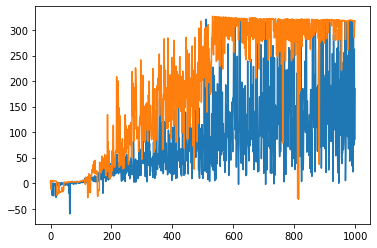

In [5]:
if train_ppo_agent==True:
    # Creating envronment
    env=Environment()
    n_states= env.n_states
    n_actions = env.n_actions
    state = env.reset()
    
    rewards_log=[]
    max_reward=0
    
    ppo_model=PPO_Model(n_actions=env.n_actions,**params_dict)
    ppo_memory = Memory(_len=(ppo_model._time_steps+ppo_model._advantage),n_states=n_states,n_actions=n_actions)
    
                
    for episode in range(ppo_model._episodes):
        
        state_input = None
        sum_reward=0
        sum_reward_log=0
        
        for itr in trange(ppo_model._time_steps+ppo_model._advantage):
            state_input = K.expand_dims(state, 0)
            mean,std = ppo_model._actor(state_input)
            q_value  = ppo_model._critic(state_input)
            action = np.random.normal(mean,std)[0]
            
            observation, reward, mask, info = env.step(action)
            
            
            sum_reward+=reward
            ppo_memory.append(state,action,mean,std,q_value,mask,reward)
            
            state = observation
            if not mask: # mask is invert of done / terminal
                sum_reward_log=copy(sum_reward)
                sum_reward=0
                env.reset()
        
        curr_states,old_actions,old_means,old_stds,values,rewards,masks = ppo_memory.retrive()
        state_input=K.expand_dims(state, 0)
        q_value = ppo_model._critic(state_input)
        values=np.concatenate([values,q_value],axis=0)
        
        for _ in trange(ppo_model._train_steps):
                adv = ppo_model._advantage
                target_qvals, advantages = ppo_model.calc_gae_values(values, masks, rewards)
                ppo_model.train_actor_network(curr_states[:-adv],old_means[:-adv],old_stds[:-adv],old_actions[:-adv],advantages)
                ppo_model.train_critic_network(curr_states[:-adv],target_qvals)                            

        avg_reward = np.mean([ppo_model.test_reward(i) for i in trange(5)])
        print('episode :',episode,'reward :',sum_reward_log)   
        print('total test reward=' + str(avg_reward))
        
        if avg_reward >=max_reward:
            ppo_model._actor.save_weights(exp_root_path+'/ppo_best_actor.hdf5')
            ppo_model._critic.save_weights(exp_root_path+'/ppo_best_critic'+'.hdf5')
            best_eps=episode
            max_reward = avg_reward
        rewards_log.append([sum_reward_log,avg_reward])
        env.reset()

    env.close()
    plt.plot(rewards_log)

### Train and Test rewards

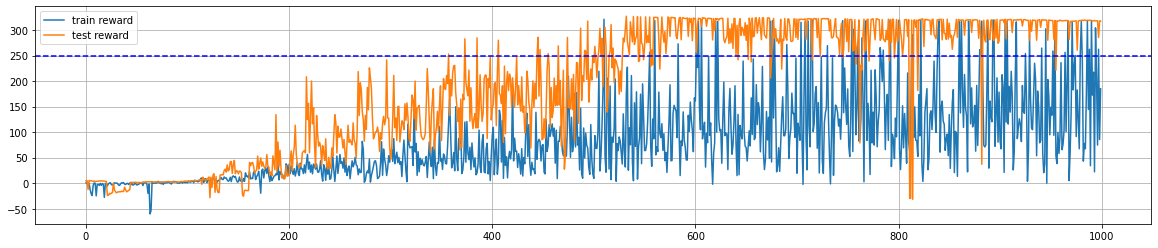

In [6]:
if train_ppo_agent==True:
    f=open(exp_root_path+'/ppo-biped-loss.pkl','wb')
    pickle.dump(rewards_log,f)
    f.close()
else: 
    f=open(exp_root_path+'/ppo-biped-loss.pkl','rb')
    rewards_log=pickle.load(f)
    f.close()
fig,axes=plt.subplots(nrows=1,ncols=1,figsize=(20,4))
axes.plot(rewards_log)
axes.legend(['train reward','test reward'])
axes.grid()
axes.axhline(y=250,color='b',linestyle='--')
fig.savefig(exp_root_path+'/bipedal-ppo.png')

### Test on Bipedal Environment

In [7]:
env = Environment()
if train_ppo_agent == False:
    ppo_model=PPO_Model(n_actions=env.n_actions,**params_dict)
_actor=ppo_model._actor
_actor(np.ones((1,env.n_states)))
_actor.load_weights(exp_root_path+'/ppo_best_actor.hdf5')

In [8]:
state=env.reset()
i=0
ter_count=0
img_save_path=exp_root_path+'/bipedal_ppo/'
if not os.path.exists(img_save_path): os.makedirs(img_save_path)
    
while True:
    action=_actor(state.reshape(1,24))
    state,rwd,mask,info=env.step(action[0][0])
    img=env.render('rgb_array')
    cv2.imwrite(img_save_path+str(i)+'.jpg',img)
    i+=1
    if mask==False:
            ter_count+=1
            state=env.reset()
    if ter_count==5:
             break
env.close()

In [9]:
fnames=[img_save_path+str(i)+'.jpg' for i in range(1000)]
with imageio.get_writer(img_save_path+'bipedal_ppo.gif', mode='I') as writer:
    for fname in tqdm(fnames):
        image = imageio.imread(fname)
        writer.append_data(image)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.69it/s]


### Saved GIF of test results

<img src = 'exps/ppo_exp_1/bipedal_ppo/bipedal_ppo.gif'>

### Thank You